In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error
from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics

import sklearn.decomposition
import sklearn.ensemble as sk


import random
import sys
from scipy import stats
from sklearn import linear_model

from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve

#Import Data

In [2]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D0_raw_features.csv', parse_dates = [0], index_col = 0)

#Randomized Principal Component Analysis

In [3]:
#from sklearn.decomposition import RandomizedPCA
#features = list(df_all.columns)
#pca = RandomizedPCA()
#df_pca = df_all[features].apply(lambda x: pca.fit_transform(x))

###Delete the unfiltered data

In [4]:
#df_all.drop(df_all.columns[[1,5]], axis=1, inplace=True)
#print df_all[:5]

##Declare whether to process raw or filtered data.

In [5]:
which_data = 0    #1 = filtered, 0 = raw
if which_data == 0:
    ref_column = 'O3_ppb'
    leave_out_pod = 'pod_o3_smooth'
    pod_ozone = 'e2v03'
else:
    ref_column = 'ref_o3_smooth'
    leave_out_pod = 'e2v03'
    pod_ozone = 'pod_o3_smooth'

####Define a function that makes numpy arrays out of the training and holdout data.

In [6]:
def make_numpy_arrays_for_tr_and_holdout(features, df_T, df_H):
    X_T = df_T[features].values
    X_H = df_H[features].values
    y_T = df_T[ref_column].values
    y_H = df_H[ref_column].values
    return X_T, y_T, X_H, y_H

####Scale the features and cadd a 'day' column to the dataframe.

In [7]:
features = list(df_all.ix[:,1:len(df_all.columns)])
def scale_features_and_create_day_column(df_all, features, ref_column):
    
    #Center feature values around zero and make them all have variance on the same order.
    df_scaled = df_all.copy()
    #for i in range(0,len(features)):
     #   df_scaled[features[i]] = pp.scale(df_all[features[i]].values)
    df_scaled = df_all[features].apply(lambda x: pp.scale(x))
    df_sc = pd.concat([df_scaled, df_all[ref_column]], axis = 1)
    #create a 'day' column in the dataframe by mapping the index column
    df_sc['day'] = df_sc.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
    days = df_sc['day'].unique()
    
    return df_sc, days

####Call the scaling function and create a dataframe with scaled data that has a day column.

In [8]:
df_scaled, days = scale_features_and_create_day_column(df_all, features, ref_column)

/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: The scale function assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
/Applications/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:145: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  Xr -= mean_
/Applications/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:147: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  Xr /= std_
/Applications/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:145: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  Xr -= mean_
/Appl

####Define a custom cross-validation function.

In [9]:
labels = df_scaled['day'].values
lol = cross_validation.LeaveOneLabelOut(labels)

####Declare a neutral fitting function.

In [10]:
#Takes a model, and training and holdout data, and returns training and holdout data
def fitting_func(model, X_T, y_T, X_H, y_H):    
    #fit a linear regression on the training data
    model.fit(X_T, y_T)   
    #find the normalized MSE for the training and holdout data
    return np.mean((y_H - model.predict(X_H))**2), np.mean((y_T - model.predict(X_T))**2)

####Define a function that loops through all of the days (CV by day), and computes MSE.

In [11]:
def cross_validation_by_day(model, features, df):

    #initialize the holdout and training MSE
    day_date = []
    MSE_H = [] 
    MSE_T = []
    #Calculate the training and holdout RSS for each step.
    #take the mean MSE for all of the possible holdout days (giving cross-validation error)
    for d in days:
        
        #call the df_subset function to make numpy arrays out of the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df[df.day != d], df[df.day == d])
                
        MSE_H_day, MSE_T_day = fitting_func(model, X_T, y_T, X_H, y_H)
         
        #record the MSE for lambda for the day
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
    
        #record the day
        day_date.append(d)
            
        #find the mean MSE of all of the days for the given value of lambda
        mean_cv_MSE_all_days = np.mean(MSE_H)
        mean_train_MSE_all_Days = np.mean(MSE_T)

    return mean_cv_MSE_all_days, mean_train_MSE_all_Days 

#Linear Regression with Base Features

In [12]:
base_features = [pod_ozone,'Temp','Rh']

In [13]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_H, MSE_T = cross_validation_by_day(lin_regr, base_features, df_scaled)
print "Holdout MSE: ", int(MSE_H), " Training MSE: ", int(MSE_T)

Holdout MSE:  62  Training MSE:  47


####Define a function to plot the learning curve

In [14]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylimit, cv, train_sizes, scoring):

    plt.figure()
    plt.title(title)
    if ylimit is not None:
        plt.ylim(ylimit)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, cv = cv, train_sizes = train_sizes, scoring = scoring)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation error")

    plt.legend(loc="best")
    return plt

###Call the learning curve function for a linear regression with the base features.

<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

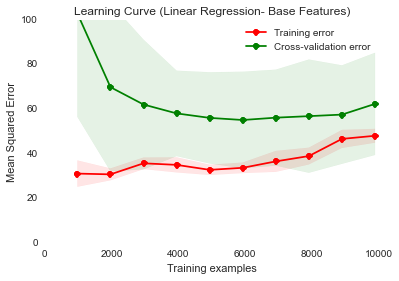

In [15]:
base_features = [pod_ozone,'Temp','Rh']

X = df_all[base_features].values
y = df_all[ref_column].values
title = "Learning Curve (Linear Regression- Base Features)"
cv = lol
ylim = (0,100)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plot_learning_curve(lin_regr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

####Plot a learning curve with all features.

<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

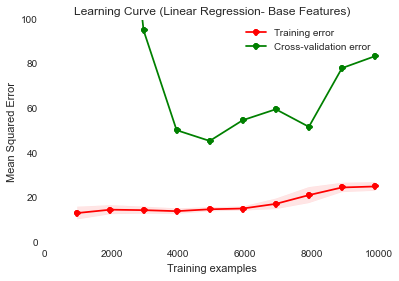

In [16]:
#change the features list to include all features and polynomials
all_features = list(df_all.ix[:,2:len(df_all.columns)])
X = df_all[all_features].values
y = df_all[ref_column].values

title = "Learning Curve (Linear Regression- Base Features)"
cv = lol
ylim = (0,100)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plot_learning_curve(lin_regr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

The uncertainty in the cross-validation score is enormous, and it's very far away, from the training score, which indicates that we now have high variance, and need to reduce the number of features.

#Forward Selection

In [382]:
from sklearn.metrics import make_scorer
def custom_scoring_function(y, y_pred):
    low_sum = np.mean(0.2*(y[y < 45] - y_pred[y < 45])**2)
    high_sum = np.mean((y[y >= 45] - y_pred[y >= 45])**2)
    if np.isnan(low_sum) == True:
        low_sum = 0
    if np.isnan(high_sum) == True:
        high_sum = 0
    ##print int(low_sum), int(high_sum)
    return int(low_sum + high_sum)

In [383]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv

In [384]:
def new_forward_selection_step(model, b_f, features, df, ref_column, scoring_metric):
    #initialize min_MSE with a very large number
    min_score = sys.maxint
    min_r2 = 0
    next_feature = ''

    for f in features:
        score_step = avg_cv_score_for_all_days(df, b_f + [f], ref_column, model, scoring_metric)
        if score_step < min_score:
            min_score = score_step
            next_feature = f
            score_cv = "{:.1f}".format(min_score)   
    return next_feature, score_cv

In [385]:
def new_forward_selection_lodo(model, features, df, scoring_metric):
    #initialize the best_features list with the base features to force their inclusion
    best_features = []
    #call the function that scales the features and creates a day column   
    
    score_cv = []
    while len(features) > 0:
        next_features = []
        score_cv_list = []
             
        next_feature, score_cv_feat = new_forward_selection_step(model, best_features, features, df, ref_column, scoring_metric)
        print next_feature, ':', score_cv_feat
        #add the next feature to the list
        best_features += [next_feature]
        score_cv.append(score_cv_feat)
        #remove the added feature from the list
        features.remove(next_feature)

    return best_features, score_cv

###Try it

In [386]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['Zenith Angle [degrees]','UnixTime',leave_out_pod, ref_column]
features = [f for f in features if f not in leave_out]
#Define the model.
lin_regr = linear_model.LinearRegression()

In [387]:
fs_features_custom, score_custom = new_forward_selection_lodo(lin_regr, features, df_scaled[[ref_column] + features].dropna(), 'custom')
print fs_features_custom

ln_temp_int_90 : 140.9
ln_O3 : 55.3
temp_int_90 : 52.0
days from start : 49.1
03_mult_temp_cu : 48.1
o3_slope_75 : 47.9
o3_slope_30 : 47.9
o3_slope_90 : 48.0
o3_slope_15 : 48.0
o3_slope_60 : 48.2
o3_slope_45 : 48.2
o3_slope_5 : 48.3
rh_slope_90 : 48.3
rh_slope_75 : 47.9
rh_slope_60 : 48.1
rh_slope_30 : 48.1
temp_int_75 : 48.1
rh_slope_45 : 48.2
rh_slope_15 : 48.3
rh_slope_5 : 48.3
temp_int_60 : 48.3
o3_int_90 : 48.3
o3_int_75 : 48.1
o3_int_60 : 48.1
temp_int_45 : 48.0
o3_int_45 : 48.6
o3_int_30 : 48.0
temp_int_30 : 48.4
diff : 48.3
O3_cu : 49.3
e2v03 : 51.1
O3_sq : 52.8
03_mult_temp_sq : 54.3
ln_temp : 54.1
ln_03_mult_temp : 54.0
temp_slope_15 : 54.1
temp_slope_30 : 54.2
temp_slope_5 : 54.2
temp_slope_45 : 54.7
temp_slope_90 : 55.1
temp_slope_60 : 55.2
temp_slope_75 : 55.4
Temp : 55.8
03_mult_temp : 57.3
03_mult_rh_cu : 60.2
03_mult_rh_&_temp_cu : 61.9
rh_cu : 65.3
03_mult_rh_sq : 69.8
temp_mult_rh_cu : 70.9
ln_rh : 62.9
temp_mult_rh : 49.6
rh_sq : 43.1
03_mult_rh_&_temp : 41.7
ln_rh_i

In [379]:
fs_features_MSE, score_MSE = new_forward_selection_lodo(lin_regr, features, df_scaled[[ref_column] + features].dropna(), 'mean_squared_error')
print fs_features

['temp_int_75', 'e2v03', 'Rh', 'temp_int_60', 'o3_slope_5', 'temp_int_45', 'temp_int_30', 'o3_slope_15', 'rh_slope_5', 'rh_slope_15', 'rh_slope_30', 'rh_slope_90', 'rh_slope_45', 'rh_slope_75', 'rh_slope_60', 'rh_int_60', 'rh_int_45', 'rh_int_90', 'rh_int_30', 'rh_int_75', 'diff', 'o3_slope_45', 'o3_slope_30', 'o3_slope_60', 'o3_slope_75', 'o3_slope_90', 'Temp', 'temp_slope_30', 'temp_slope_45', 'temp_slope_75', 'temp_slope_60', 'temp_slope_90', 'temp_slope_15', 'temp_slope_5']


['140.9', '55.3', '52.0', '49.1', '48.1', '47.9', '47.9', '48.0', '48.0', '48.2', '48.2', '48.3', '48.3', '47.9', '48.1', '48.1', '48.1', '48.2', '48.3', '48.3', '48.3', '48.3', '48.1', '48.1', '48.0', '48.6', '48.0', '48.4', '48.3', '49.3', '51.1', '52.8', '54.3', '54.1', '54.0', '54.1', '54.2', '54.2', '54.7', '55.1', '55.2', '55.4', '55.8', '57.3', '60.2', '61.9', '65.3', '69.8', '70.9', '62.9', '49.6', '43.1', '41.7', '39.4', '39.2', '39.2', '38.8', '39.1', '39.0', '39.3', '39.1', '38.9', '39.6', '41.6', '43.2', '46.6', '52.9', '55.4']


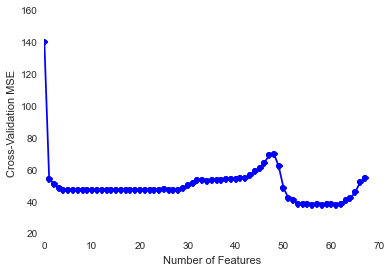

In [390]:
x = range(0, len(score_custom))
plt.figure()
plt.plot(x, score_custom, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation MSE')
print score_custom

[]


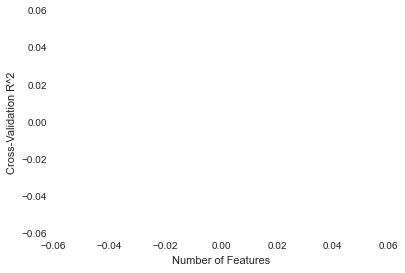

In [268]:
x = range(0, len(MSE_cv_r2))
plt.figure()
plt.plot(x, MSE_cv_r2, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation R^2')
print MSE_cv_r2

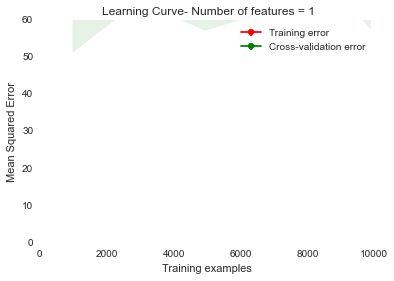

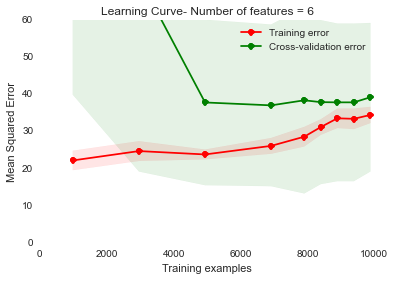

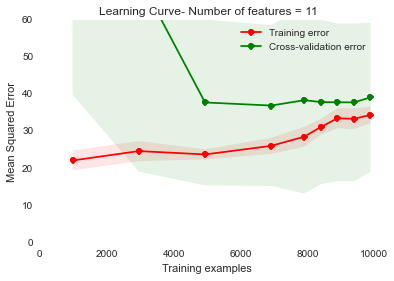

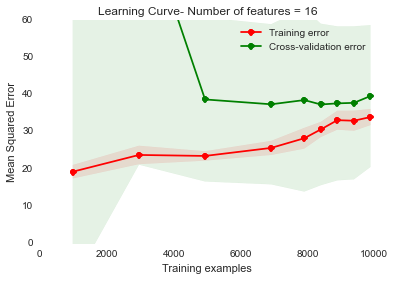

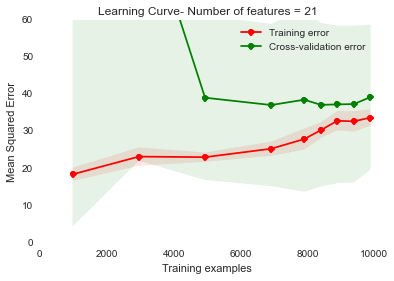

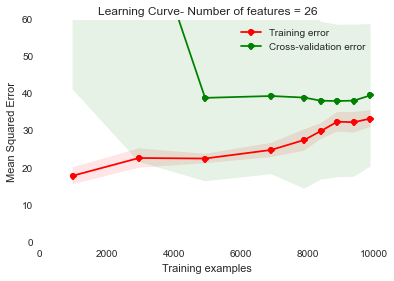

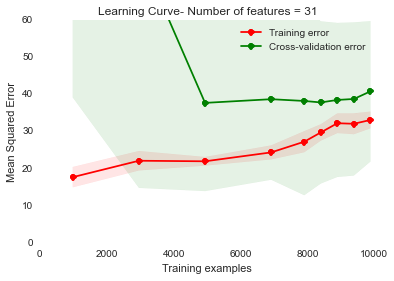

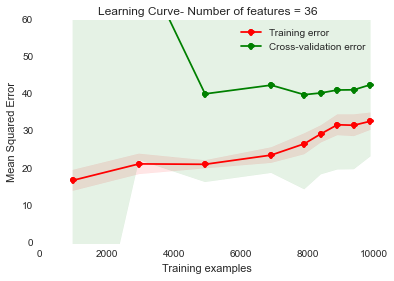

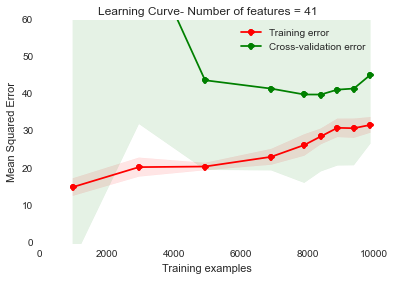

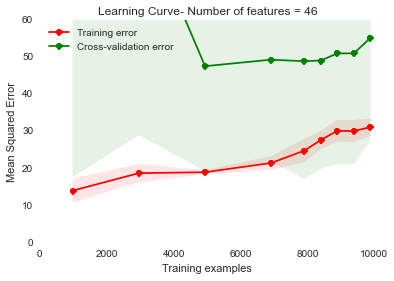

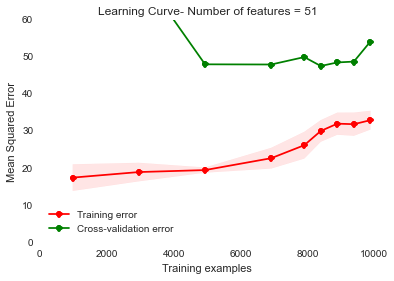

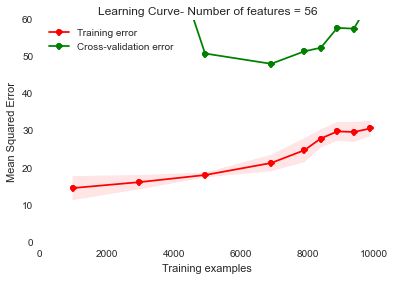

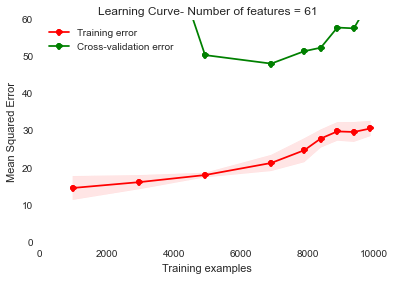

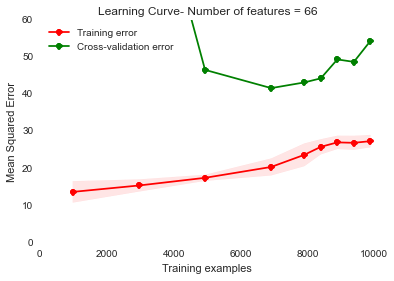

In [255]:
cv = lol
ylim = (0,60)
train_sizes = np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0])
#declare the reference data 
y = df_scaled[ref_column].values

i = 1
while i <= len(fs_features):
    X = df_all[fs_features[:i]].values 
    title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(lin_regr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')
    i += 5

#Check Residuals

In [394]:
def fitted_vs_ref_plot(df):
    plt.figure(figsize = (5,5))
    plt.plot(df[ref_column],df.O3_fit,linestyle = '',marker = '.',alpha = 0.3)
    plt.xlabel('Reference O3 Conc.')
    plt.ylabel('Predicted O3 Conc (Holdout)')
    plt.plot([1,df[ref_column].max()],[1,df[ref_column].max()])

In [395]:
def plot_fitted_and_ref_vs_time(df,xlim):
    plt.figure(figsize = (15,10))
    df_lin_regr_best_feat[ref_column].plot(marker = '.',linestyle = ' ',)
    df_lin_regr_best_feat.O3_fit.plot(marker = '.',linestyle = '-', xlim=xlim)
    plt.ylabel('Residual Value')

In [396]:
def plot_resid_vs_conc(df):
    #find the residuals
    resid = df[ref_column] - df.O3_fit
    #plot the residuals to check for non-linearity of response predictor
    plt.figure(figsize = (15,5))
    plt.plot(df.O3_fit,lin_resid,linestyle = '',marker = '.',alpha = 0.4)
    plt.plot([-40,70],[0,0], linestyle = '--')
    plt.xlabel('Fitted O3 Conc.')
    plt.ylabel('Residuals')
    return resid

In [397]:
def plot_resid_vs_time(resid, xlim):
    plt.figure(figsize = (15,5))
    resid.plot(linestyle = '',marker = '.', xlim = xlim)
    #plt.plot([0,0],[70,0])
    plt.xlabel('Fitted O3 Conc.')
    plt.ylabel('Residuals')

###Find predicted ozone values for the holdout data. Enter the number of good features to use for regressions.

In [398]:
def find_fitted_cv_values_for_best_features(df, fs_features, num_good_feat, Model):
    fitted_holdout_o3 = []
    for d in days:    
        #call the df_subset function to make numpy arrays out of the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df[df.day != d], df[df.day == d]) 
        #fit a linear regression on the training data
        model = Model
        model.fit(X_T, y_T)
        
        if d == days[0]:
            fitted_holdout_o3 = model.predict(X_H)
        else:
            fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, model.predict(X_H)))

    df_lin_regr_best_feat = df_all.copy()
    df_lin_regr_best_feat['O3_fit'] = fitted_holdout_o3
    return df_lin_regr_best_feat

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


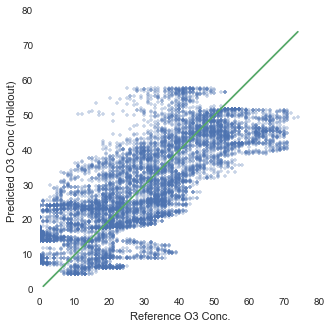

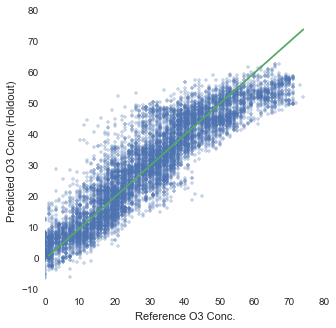

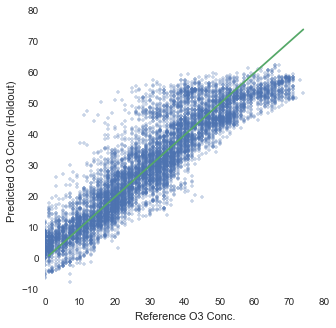

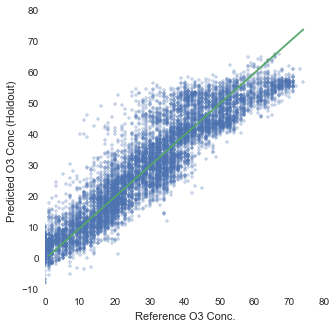

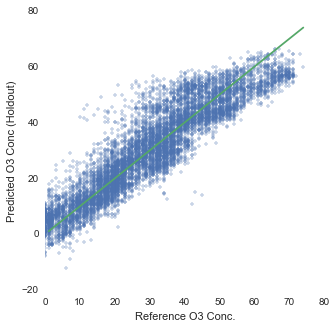

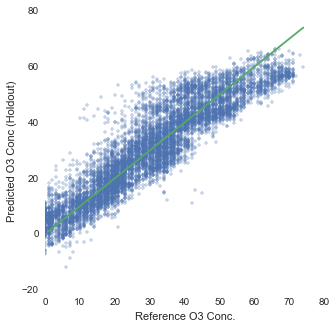

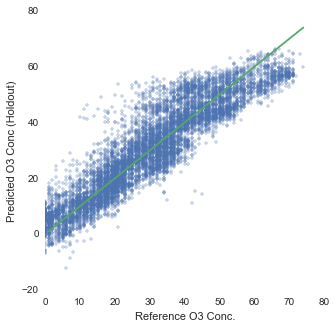

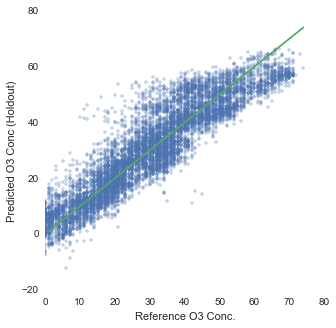

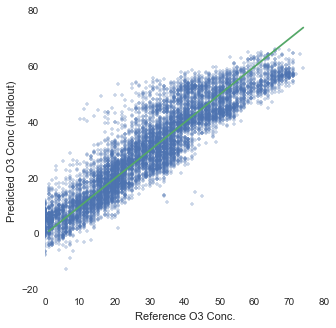

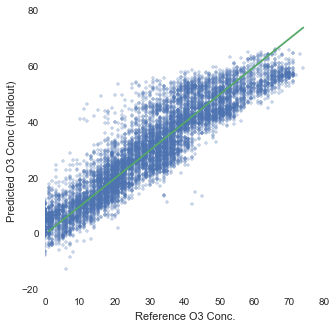

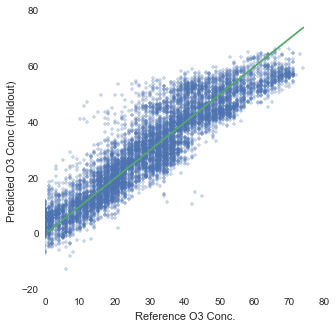

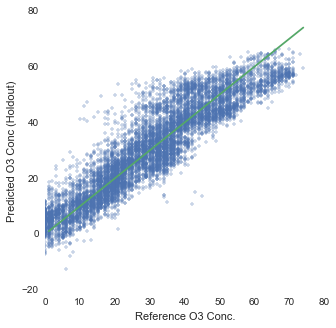

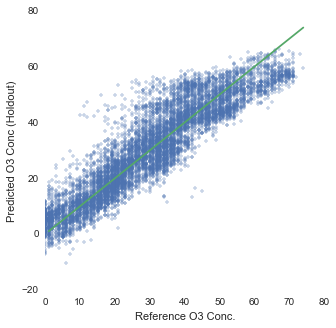

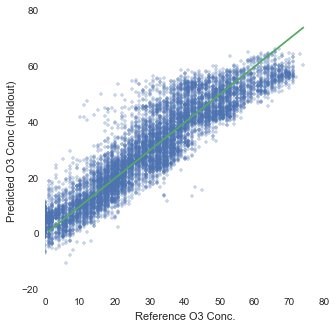

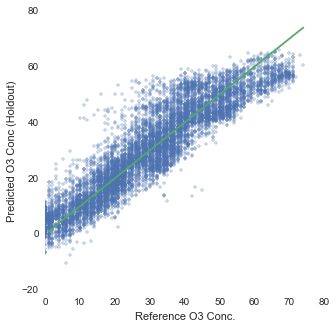

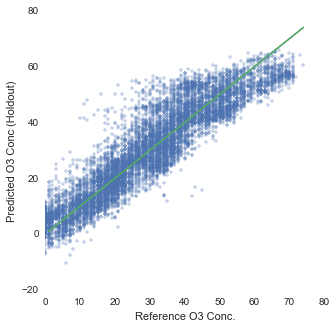

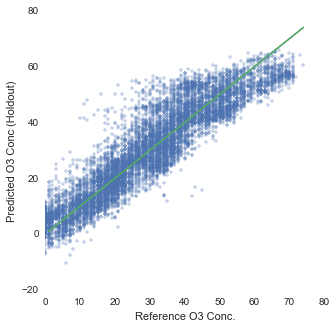

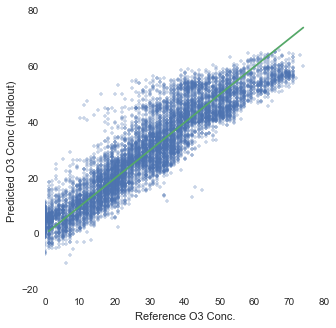

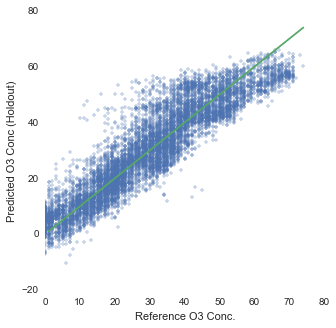

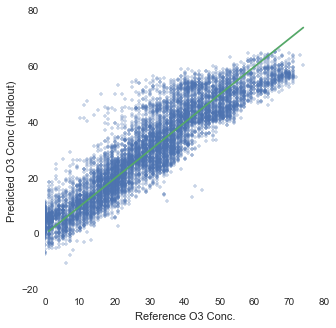

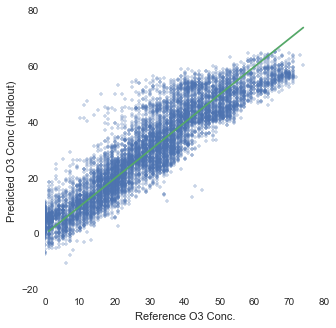

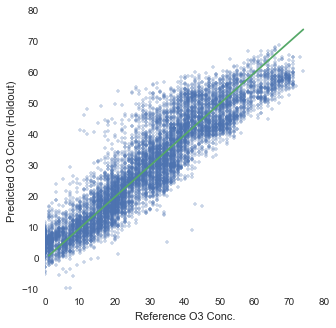

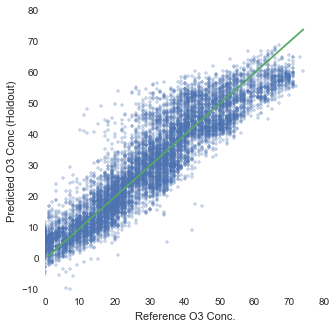

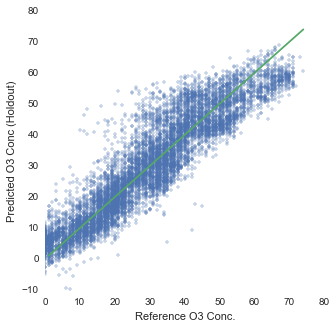

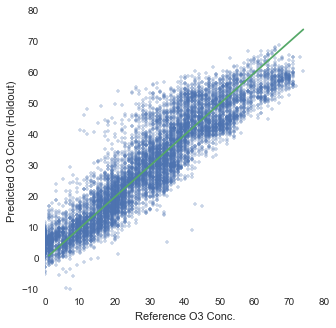

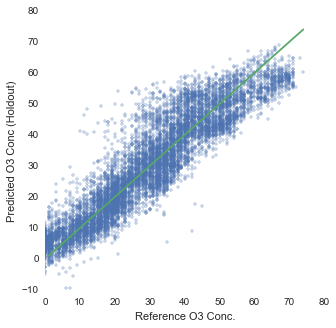

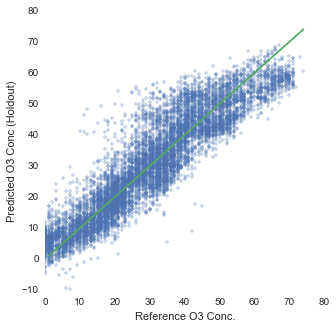

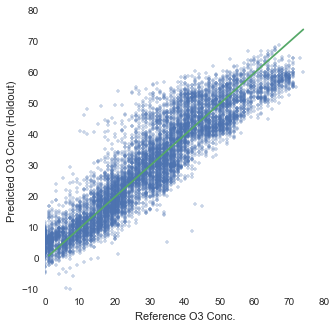

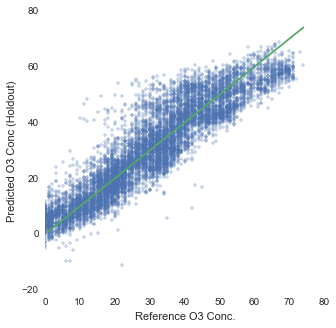

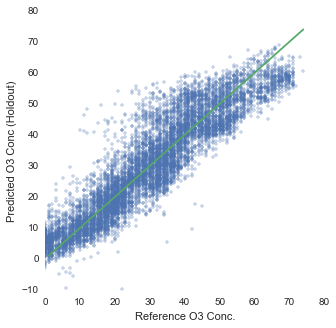

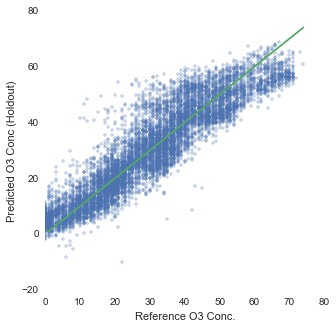

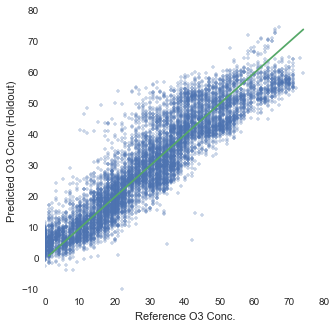

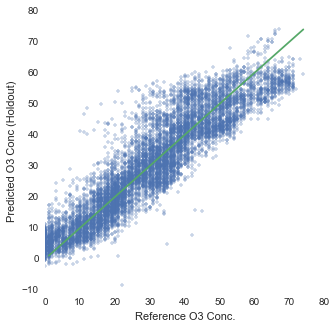

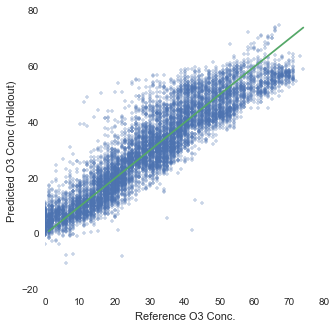

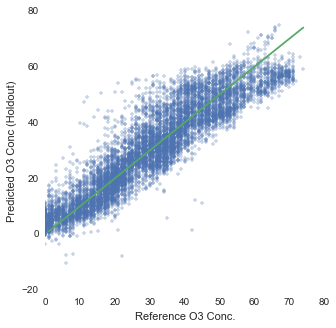

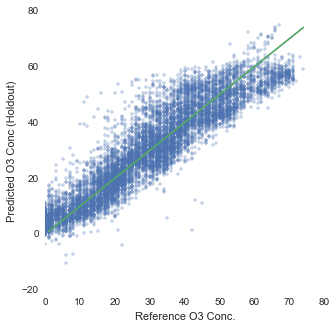

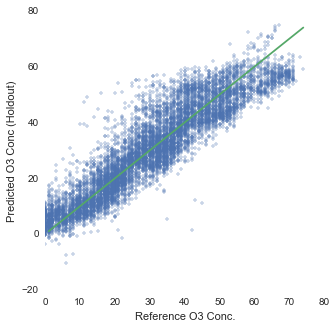

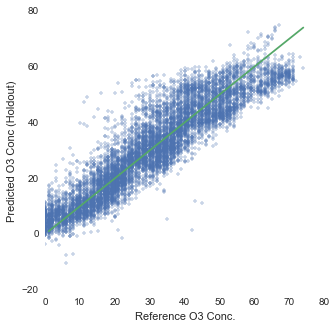

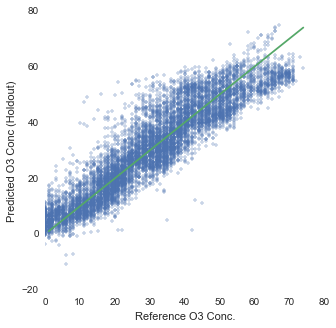

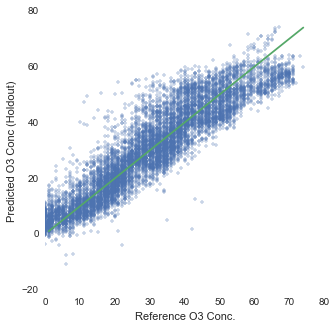

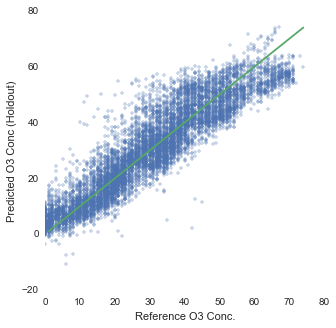

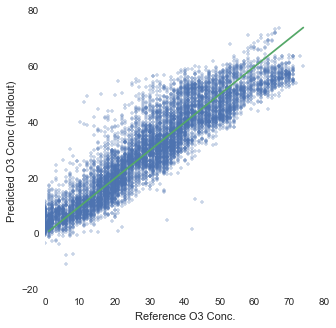

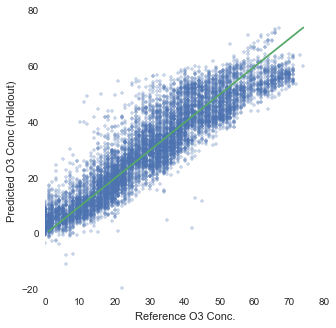

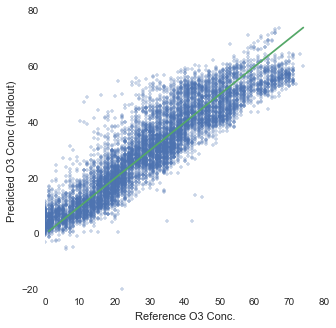

In [399]:
for i in range(1,45):
    num_good_feat = i
    df = find_fitted_cv_values_for_best_features(df_scaled, fs_features_custom, num_good_feat, linear_model.LinearRegression())
    fitted_vs_ref_plot(df) 

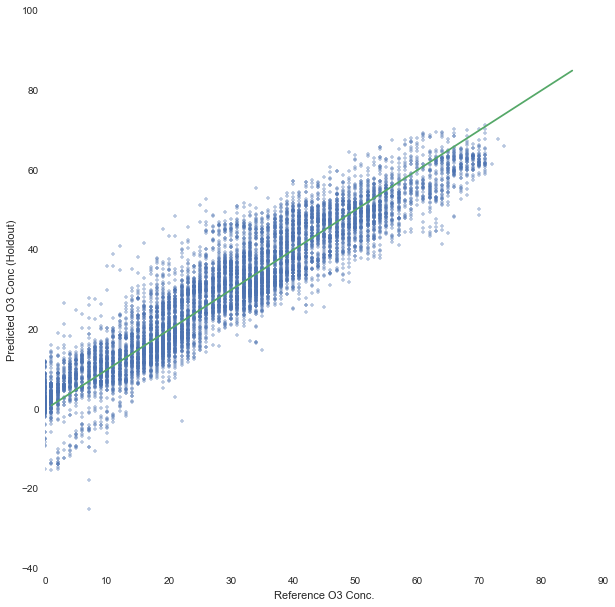

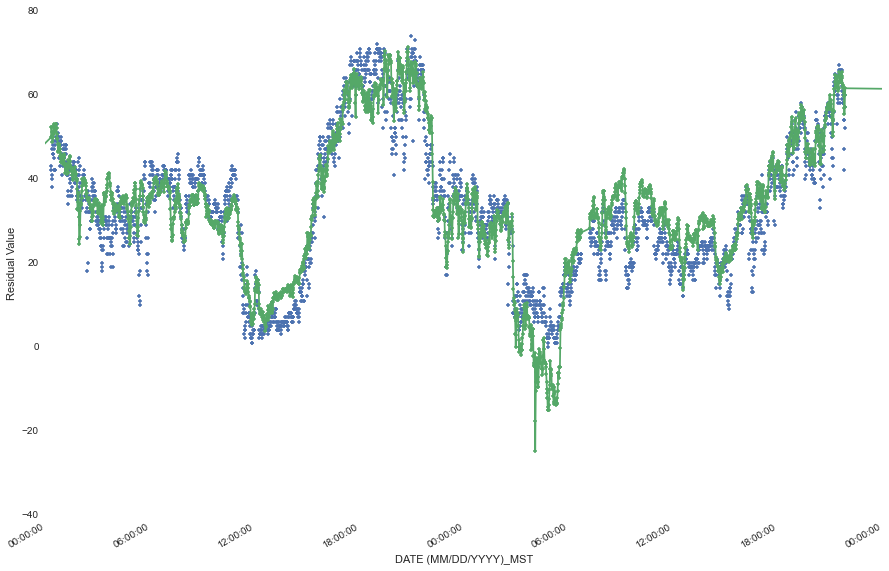

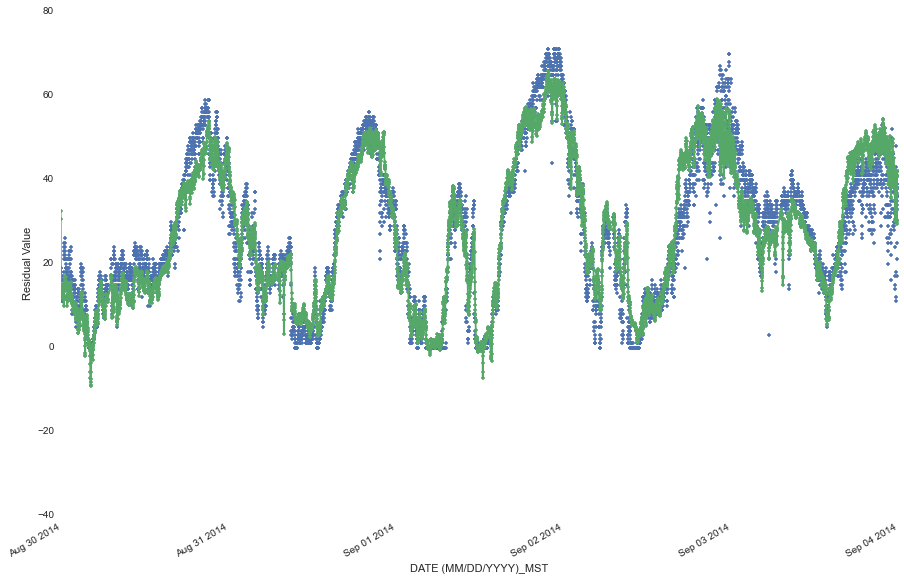

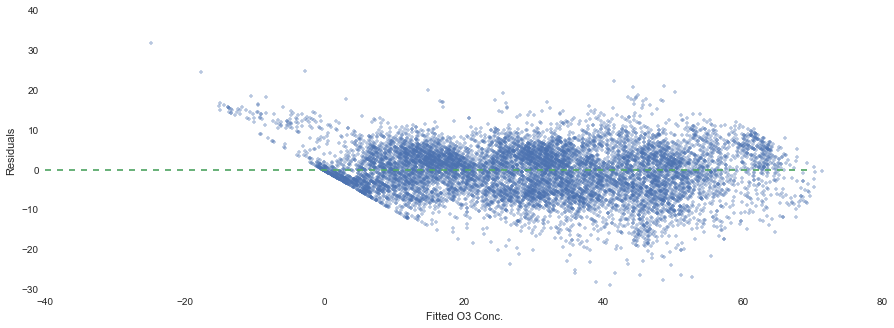

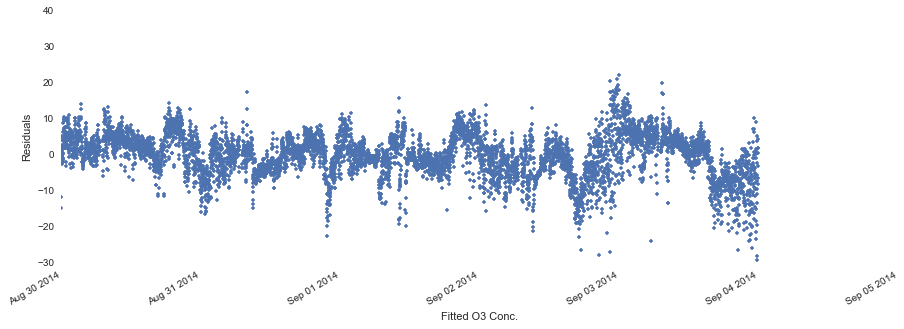

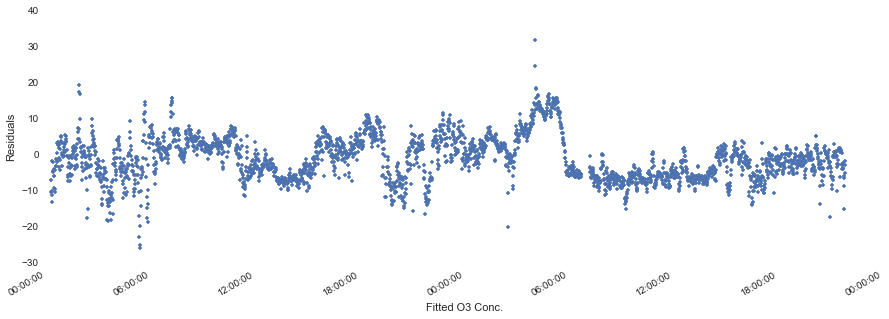

In [239]:
fitted_vs_ref_plot(df_lin_regr_best_feat)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_lin_regr_best_feat)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

In [214]:
print ("Mean Squared Error: %.2f" %
        np.mean((df_lin_regr_best_feat[ref_column] - df_lin_regr_best_feat['O3_fit']) ** 2))

Mean Squared Error: 36.86


#Ridge Regression

In [105]:
#fs_features = ['e2v03','Temp','Rh']
num_good_feat = len(fs_features)

In [119]:
#define the training data
df_ridge = df_scaled[fs_features[:num_good_feat] + [ref_column]+ ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values
#print df_fit[:5]

###Find the best lambda value using cross-validation

In [161]:
def find_best_lambda(Model, features, df):
    lambda_ridge = []
    mean_MSE_lambda_all_days = []
    day_date = []
    i = 0.00000000005
    n = 1
    coefs = []

    while i < 100:
        model = Model(alpha=i)
        MSE_ridge = []
    
        #initialize the holdout and training RSS
        MSE_T_day = []
        MSE_H_day = [] 
        #Calculate the training and holdout RSS for each step.
        #take the mean MSE for all of the possible holdout days (giving cross-validation error)
        for d in days:
                
            #call the function that defines the training and holdout data
            X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df[df.day != d], df[df.day == d])  
            #fit the ridge regression for the lambda
            model.fit(X_T, y_T)
            #get the cross-validation MSE for the lambda and day
            MSE_H_day = int(np.mean((y_H - model.predict(X_H))**2))
            #record the MSE for lambda for the day
            MSE_ridge.append(MSE_H_day)
            #record the day
            day_date.append(d)

        #find the mean MSE of all of the days for the given value of lambda
        mean_MSE_lambda_all_days.append(np.mean(MSE_ridge))
        #record the lambda value for this run
        lambda_ridge.append(i)
        #record the coefficients for this run
        coefs.append(model.coef_)
        
        i = i*2
        n += 1
    

    #find the lambda value (that produces the lowest cross-validation MSE)  
    best_lambda = lambda_ridge[mean_MSE_lambda_all_days.index(min(mean_MSE_lambda_all_days))]
                                
    #plot the coefficients     
    ax = plt.gca()
    ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

    ax.plot(lambda_ridge, coefs)
    ax.set_xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('weights')
    plt.title(str(Model) + 'coefficients as a function of the regularization')
    plt.show()  

    
    #plot the results
    plt.plot(lambda_ridge, mean_MSE_lambda_all_days)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('Cross-Validation MSE')
    
    return best_lambda, min(mean_MSE_lambda_all_days)

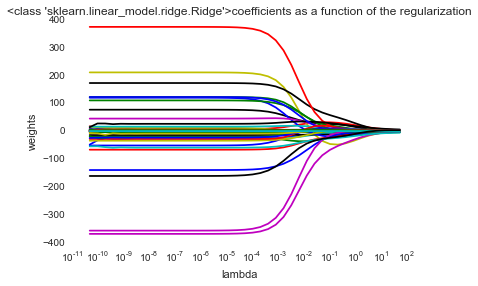

Best Lambda:  0.1073741824
Holdout Mean Squared Error:  54


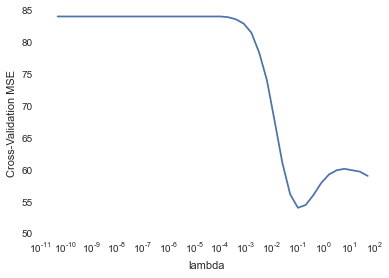

In [162]:
best_lambda, MSE_H = find_best_lambda(Ridge, fs_features[:num_good_feat], df_ridge)
print 'Best Lambda: ', best_lambda
print 'Holdout Mean Squared Error: ', int(MSE_H)

####Use the best lambda value found above to find holdout values.

In [181]:
def find_residuals_and_fitted_cv_values(Model, df_scaled, features, df_all):
    model = Model(alpha = best_lambda)

    for d in days:               
        #call the function that defines the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d])  
        #fit the ridge regression for the lambda
        model.fit(X_T, y_T)
        if d == days[0]:
            fitted_holdout_o3 = model.predict(X_H)
        else:
            fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, model.predict(X_H)))
                
    df_ridge_fit = df_all.copy()
    df_ridge_fit['O3_fit'] = fitted_holdout_o3
    return df_ridge_fit

In [182]:
df_ridge_fit = find_residuals_and_fitted_cv_values(Ridge, df_scaled, fs_features[:num_good_feat], df_all)

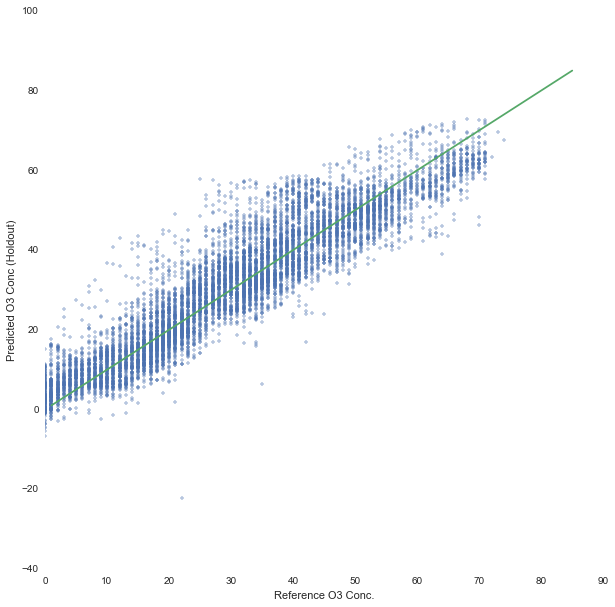

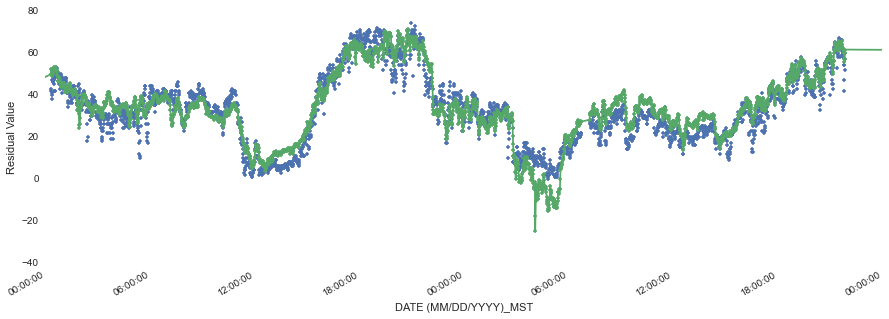

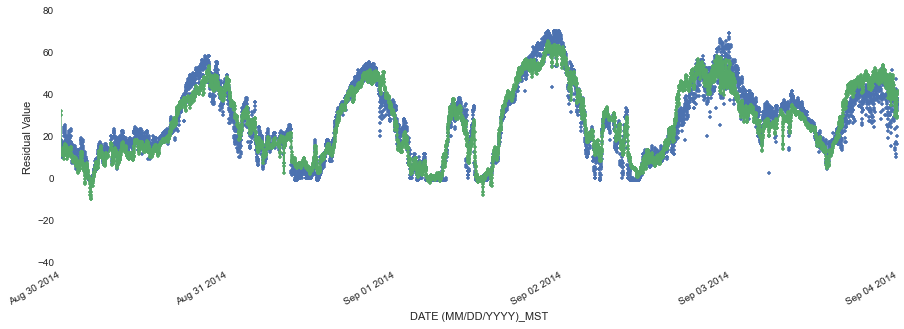

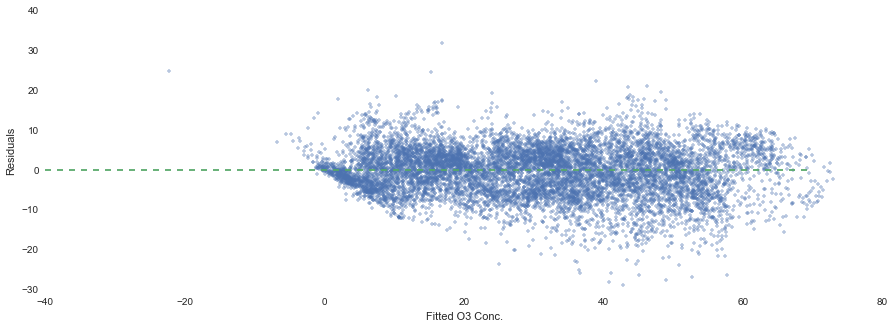

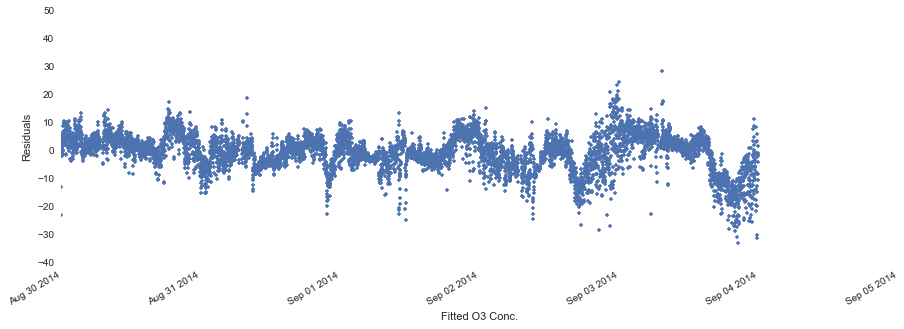

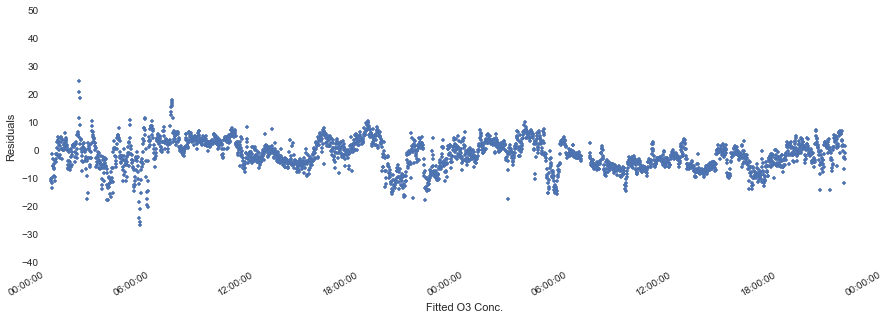

In [229]:
fitted_vs_ref_plot(df_ridge_fit)
plot_fitted_and_ref_vs_time(df_ridge_fit, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_ridge_fit, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_ridge_fit)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

In [230]:
ridge.coef_

array([-0.81260468,  0.63219375, -1.33121226,  0.30456721,  2.78538737,
        0.17477455, -0.04782321, -0.05472525, -0.2308555 ,  0.26777194,
        0.54757589, -0.12946547, -0.22099374, -0.75924286,  1.25750823,
        0.15102949,  0.24198948,  0.27655464, -0.07470202, -0.18135071,
       -0.57414543, -0.89107556, -1.50480073, -0.14662273,  0.06648045,
       -0.18339189, -0.57414543,  0.27204956,  1.40404553, -0.4640317 ,
       -0.14035083, -0.57414543,  0.56840792,  0.55393908, -0.75847727,
       -0.0978439 ,  0.19522992, -1.66063472, -0.16386436, -0.57414543,
       -0.03477215, -0.29374258, -0.81526441, -0.04655053,  0.42116889,
       -2.30010499, -0.18203181, -0.57414543, -0.53155301, -0.35229128,
       -0.19923906, -0.61284608,  0.30456721,  0.72147682,  0.07159522,
        1.40404553,  0.30456721,  1.40404553, -0.16095403, -0.48622122,
        0.30456721, -0.39296   ,  1.40404553, -0.0282418 ,  0.30456721,
        1.40404553, -0.14300071,  2.00889546])

#Lasso

In [134]:
#define the training data
df_lasso = df_scaled[fs_features[:num_good_feat] + [ref_column]+ ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values
#print df_fit[:5]

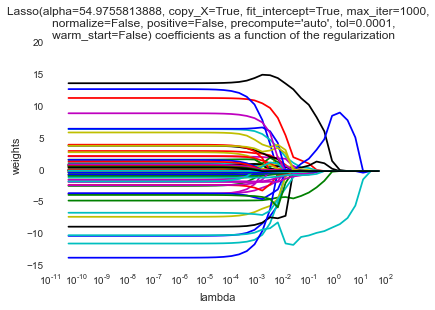

Best Lambda:  0.2147483648
Holdout Mean Squared Error:  46


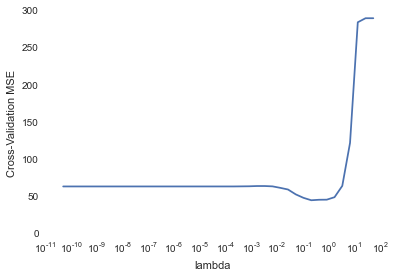

In [158]:
best_lambda, MSE_H = find_best_lambda(Lasso, fs_features[:num_good_feat], df_fit)
print 'Best Lambda: ', best_lambda
print 'Holdout Mean Squared Error: ', int(MSE_H)

####Use the best lambda value found above to find holdout values.

In [186]:
df_fit_lasso = find_residuals_and_fitted_cv_values(Lasso, df_scaled, fs_features[:num_good_feat], df_all)

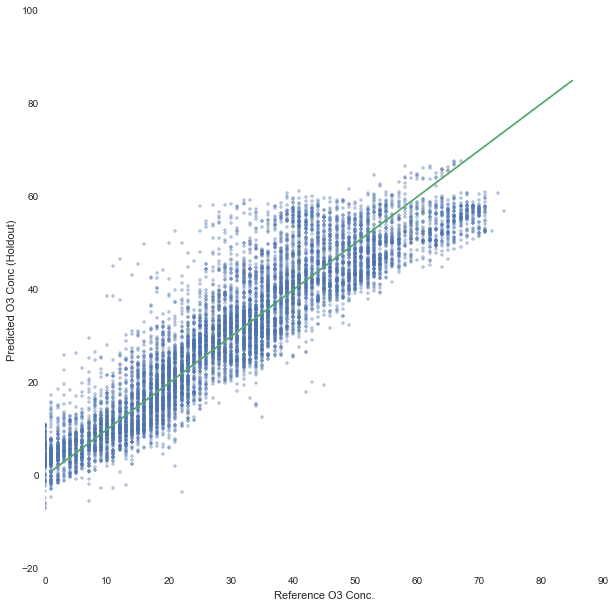

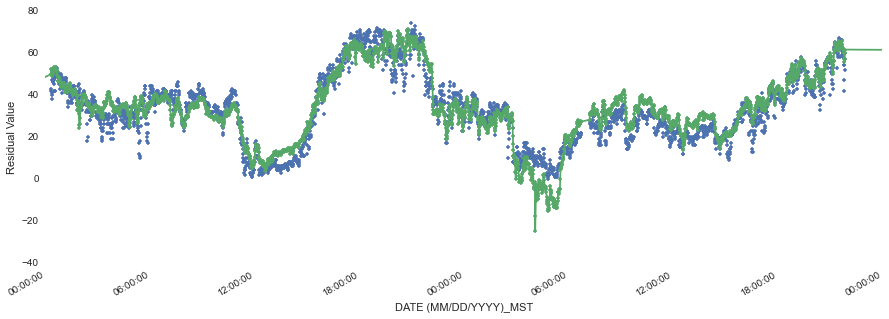

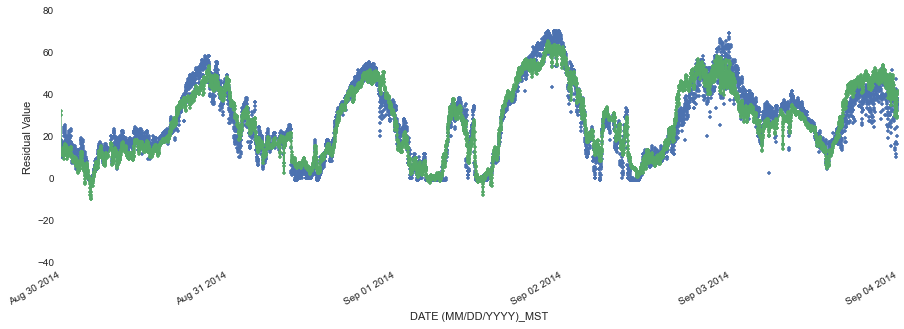

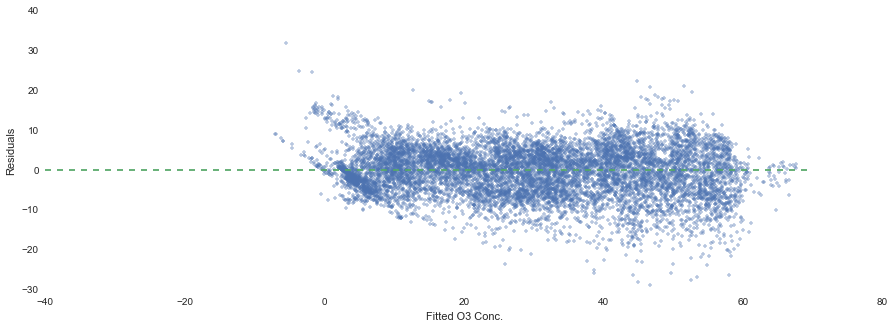

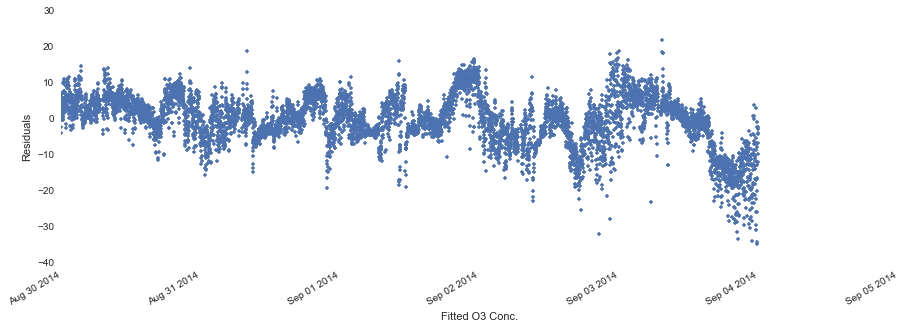

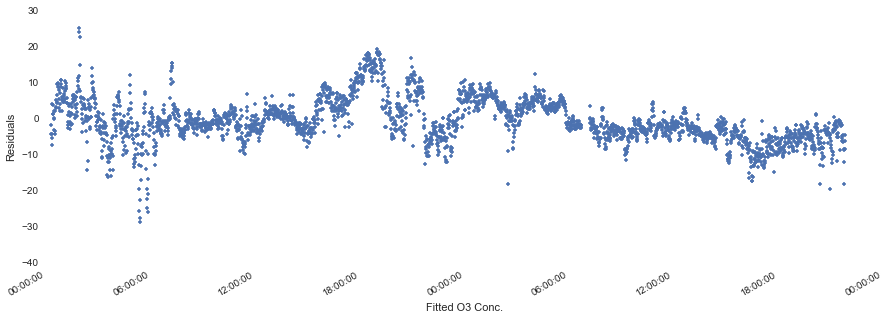

In [231]:
fitted_vs_ref_plot(df_fit_lasso)
plot_fitted_and_ref_vs_time(df_fit_lasso, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_fit_lasso, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_fit_lasso)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

#Partial Least Squares Regression

In [115]:
fs_features = ['ln_03_mult_rh', 'ln_temp_mult_rh', 'temp_slope_90', 'rh_int_90', 'temp_cu', 'temp_mult_rh', 'temp_mult_rh_sq', '03_mult_rh', '03_mult_rh_sq', '03_mult_rh_cu', 'ln_rh_int_90', '03_mult_rh_&_temp_cu', 'days from start', 'temp_sq', 'rh_cu', 'rh_sq', '03_mult_rh_&_temp_sq', '03_mult_temp_cu', 'o3_slope_75', '03_mult_temp_sq', 'rh_slope_90', 'temp_mult_rh_cu', 'temp_slope_5', 'o3_int_90', 'o3_slope_90', 'pod_o3_smooth', 'o3_slope_30', '03_mult_rh_&_temp', 'temp_int_90', 'temp_slope_75', 'o3_slope_60', 'temp_slope_60', '03_mult_temp', 'ln_temp', 'Rh', 'O3_sq', 'O3_cu', 'o3_slope_5', 'ln_03_mult_temp', 'diff', 'ln_O3', 'o3_slope_15', 'o3_slope_45', 'temp_slope_30', 'Temp', 'ln_03_mult_rh_&_temp_cu', 'rh_int_75', 'o3_int_75', 'rh_int_60', 'rh_slope_60', 'ln_temp_int_90', 'o3_int_60', 'ln_rh', 'rh_slope_45', 'temp_slope_45', 'rh_int_45', 'rh_slope_5', 'rh_int_30', 'o3_int_45', 'rh_slope_75', 'o3_int_30', 'temp_int_75', 'rh_slope_15', 'rh_slope_30', 'temp_int_60', 'temp_int_45', 'temp_int_30', 'temp_slope_15']
num_good_feat = len(fs_features)
print fs_features

['ln_03_mult_rh', 'ln_temp_mult_rh', 'temp_slope_90', 'rh_int_90', 'temp_cu', 'temp_mult_rh', 'temp_mult_rh_sq', '03_mult_rh', '03_mult_rh_sq', '03_mult_rh_cu', 'ln_rh_int_90', '03_mult_rh_&_temp_cu', 'days from start', 'temp_sq', 'rh_cu', 'rh_sq', '03_mult_rh_&_temp_sq', '03_mult_temp_cu', 'o3_slope_75', '03_mult_temp_sq', 'rh_slope_90', 'temp_mult_rh_cu', 'temp_slope_5', 'o3_int_90', 'o3_slope_90', 'pod_o3_smooth', 'o3_slope_30', '03_mult_rh_&_temp', 'temp_int_90', 'temp_slope_75', 'o3_slope_60', 'temp_slope_60', '03_mult_temp', 'ln_temp', 'Rh', 'O3_sq', 'O3_cu', 'o3_slope_5', 'ln_03_mult_temp', 'diff', 'ln_O3', 'o3_slope_15', 'o3_slope_45', 'temp_slope_30', 'Temp', 'ln_03_mult_rh_&_temp_cu', 'rh_int_75', 'o3_int_75', 'rh_int_60', 'rh_slope_60', 'ln_temp_int_90', 'o3_int_60', 'ln_rh', 'rh_slope_45', 'temp_slope_45', 'rh_int_45', 'rh_slope_5', 'rh_int_30', 'o3_int_45', 'rh_slope_75', 'o3_int_30', 'temp_int_75', 'rh_slope_15', 'rh_slope_30', 'temp_int_60', 'temp_int_45', 'temp_int_30',

In [151]:
#call the function that scales the features and creates a day column
df_fit, days = scale_features_and_create_day_column(df_all, fs_features[:num_good_feat], ref_column)

plsr = PLSRegression(max_iter = 500, n_components = 15)

#initialize the holdout and training MSE
day_date = []
MSE_H = [] 
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
                
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d])  
    
    #fit the ridge regression for the lambda
    plsr.fit(X_T, y_T)
         
    #get the cross-validation MSE for the lambda and day
    MSE_H_day = int(np.mean((y_H - plsr.predict(X_H))**2))
    
    #record the MSE for lambda for the day
    MSE_H.append(MSE_H_day)

    #record the day
    day_date.append(d)
            
    #find the mean MSE of all of the days for the given value of lambda
    mean_MSE_all_days = np.mean(MSE_H)

    
print 'MSE Holdout: ', mean_MSE_all_days    

MSE Holdout:  478.666666667


In [234]:
plsr = PLSRegression(max_iter = 500, n_components = 15)

for d in days:               
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d])  
    
    #fit the ridge regression for the lambda
    plsr.fit(X_T, y_T)
    
    if d == days[0]:
        fitted_holdout_o3 = plsr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, plsr.predict(X_H)))

df_fit_plsr = df_all.copy()
df_fit_plsr['O3_fit'] = fitted_holdout_o3

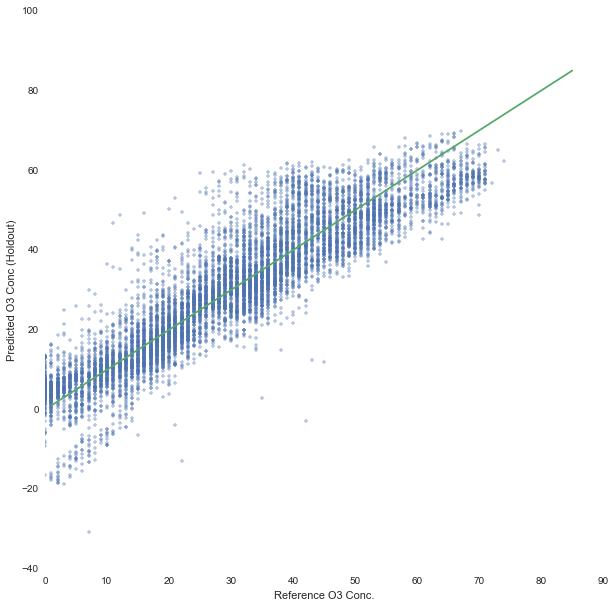

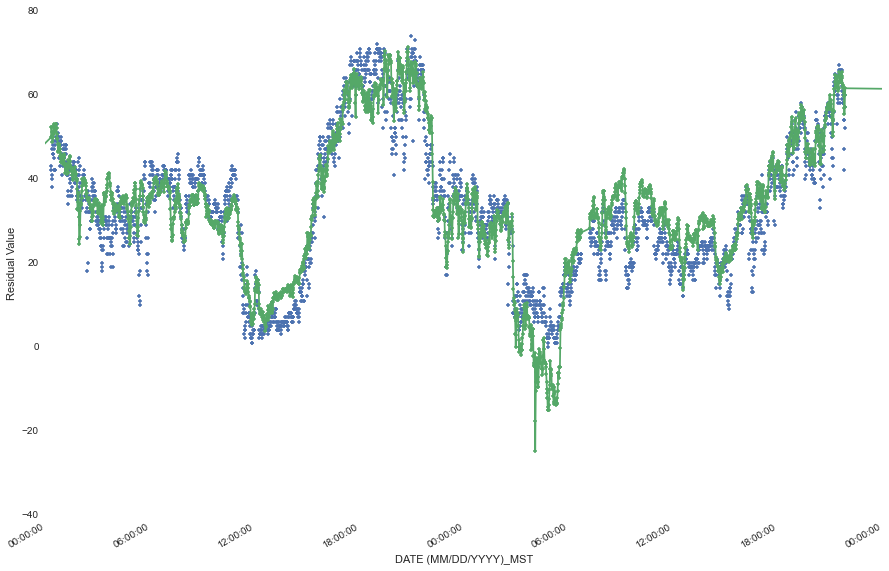

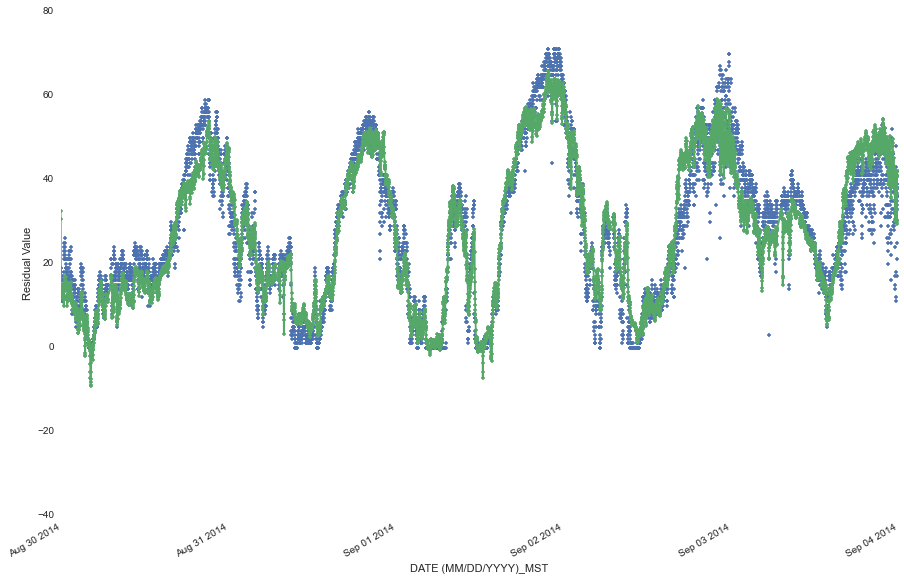

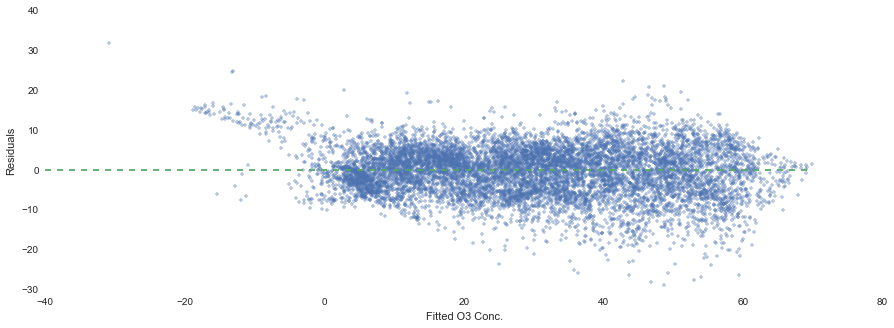

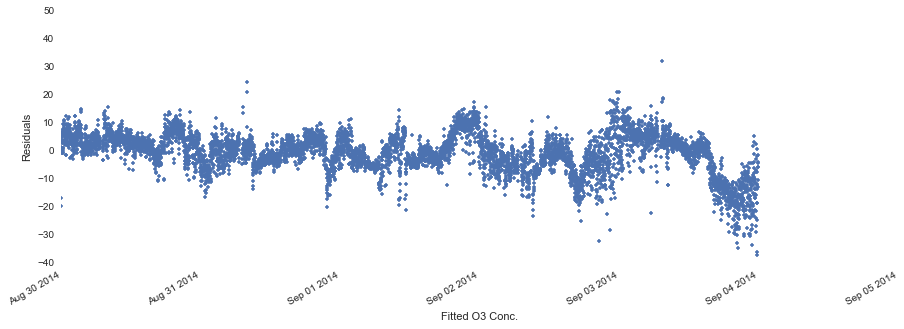

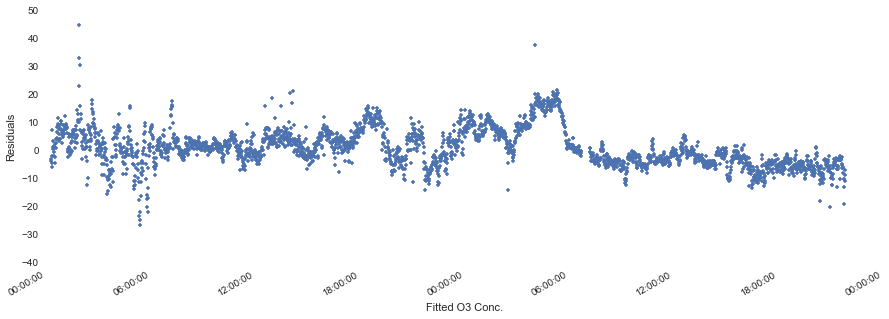

In [240]:
fitted_vs_ref_plot(df_fit_plsr)
plot_fitted_and_ref_vs_time(df_fit_plsr, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_fit_plsr, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_fit_plsr)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

#Random Forest with all features

In [96]:
fs_features = features
num_good_feat = len(fs_features)

In [97]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 0

In [98]:
import sklearn.ensemble as sk
i_max = 1 # max features
j_max = 1 # max depth
i_min = 0
j_min = 0

#fit random forest and finds MSE
def fit_rfr_and_find_MSE(features, df_F, df_H,d):
    #initialize the numpy array that will hold the test-mse data
    mse_array_test = np.zeros((i_max,j_max))
    mse_array_train = np.zeros((i_max,j_max))
    
    if options == 0:
        rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
        forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
        
        #call the function that defines the trainig and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])                
        
        #fit a linear regression on the training data
        rfr.fit(X_T, y_T)  
        
        #fit the holdout data for the day
        df_H['O3_fit'] = rfr.predict(X_H)
        
        #plot the feature importances
        plot_importance(rfr, forest)
        plot_ref_and_pod_ozone_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        plot_temp_and_rh_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        plot_fitted_and_ref_ozone_for_each_day(df_H['O3_fit'], df_fit[df_fit.day == d])
        
        MSE_H = int(np.mean((y_H - rfr.predict(X_H))**2))
        MSE_T = int(np.mean((y_T - rfr.predict(X_T))**2))
            
        print d,'Holdout MSE: ', int(np.mean((y_H - rfr.predict(X_H))**2))
        return MSE_H, MSE_T
        
    else:
        #loop through all combinations of max_features and max_depth
        for i in range(i_min,i_max):
            j = j_min
            while j < j_max:
                #Set up the random forest regression features
                rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True, n_jobs = -1, max_features = i+1, max_depth = j+1)
                forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
                        
                #call the r=function that defines the trainig and holdout data
                X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
                
                #fit a linear regression on the training data
                rfr.fit(X_T, y_T)  
                #plot_importance(rfr, forest)
            
                #add the mse for each i and j to the 2D array (i is on one axis, j is on the other, and mse is a grid)
                mse_array_test[i,j] = int(np.mean((y_H - rfr.predict(X_H))**2))
                mse_array_train[i,j] = int(np.mean((y_T - rfr.predict(X_T))**2))
            
                print d,i,j,int(np.mean((y_H - rfr.predict(X_H))**2))
                j += 10
               
        #find the MSE for the training and holdout data
        return mse_array_test, mse_array_train

In [80]:
def plot_importance(rfr,forest):
    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    print std
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(len(fs_features)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])),fs_features[indices[f]]
    
    #Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(len(fs_features)), importances[indices], color="r", align="center")
    #, yerr = std[indices]
    plt.xticks(range(len(fs_features)), indices)
    plt.xlim([-1, len(fs_features)])
    plt.show()
    
def plot_temp_and_rh_for_each_day(df_T, df_H):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title('Temp and Rh Data', fontsize = 30)
    ax.plot(df_H['Temp'],  color="r", marker = '.', linestyle = '--', label = 'reference')
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Temperature (as % of maximum)', fontsize = 18)
    ax.legend()
    
    ax2 = ax.twinx()  
    ax2.set_ylabel('Rel. Hum. (as % of maximum)', fontsize = 18)
    ax2.legend(loc = 0)
    plt.plot((df_H['Rh']), marker = '.', linestyle = '--', label = 'pod')
    plt.show()
    
def plot_ref_and_pod_ozone_for_each_day(df_T, df_H):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title('Pod and Reference Ozone Data', fontsize = 30)
    ax.plot(df_H['O3_ppb'], color="r", marker = '.', linestyle = '--', label = 'reference')
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Reference Ozone', fontsize = 18)
    ax.legend()
    
    
    df_H['ones'] = 1
    df_H['inverse_o3'] = df_H['ones'].div(df_H['e2v03'], axis='index')
    ax2 = ax.twinx()  
    ax2.set_ylabel('Pod Ozone (1/mV)', fontsize = 18)
    ax2.legend(loc = 0)
    plt.plot((df_H['inverse_o3']), marker = '.', linestyle = '--', label = 'pod')
    plt.show()
    
    
def plot_fitted_and_ref_ozone_for_each_day(fitted_data, df_H):
    plt.figure(figsize=(15,5))
    plt.title('Fitted and Ref. Ozone Data', fontsize = 30)
    fitted_data.plot(color="r", marker = '.', label = 'fitted')
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Ozone (ppb)', fontsize = 18)
    plt.legend() 
    df_H['O3_ppb'].plot(label = 'reference')
    plt.show()

In [100]:
def find_daily_min_max(features, df_T, df_H,d):
    X_T = df_T[features]
    X_H = df_H[features]
    y_T = df_T['O3_ppb']
    y_H = df_H['O3_ppb']
    return y_H.max(), df_H['Temp'].max(), df_H['Rh'].max(), y_H.min(), df_H['Temp'].min(), df_H['Rh'].min(), y_H.mean(), df_H['Temp'].mean(), df_H['Rh'].mean(), y_H.std(), df_H['Temp'].std(), df_H['Rh'].std(), df_H['e2v03'].max(), df_H['e2v03'].min(), df_H['e2v03'].mean(), df_H['e2v03'].std()

nan
Feature ranking:
1. feature 33 (0.099558) temp_int_90
2. feature 34 (0.087395) temp_int_75
3. feature 35 (0.072780) temp_int_60
4. feature 45 (0.071094) ln_O3
5. feature 37 (0.068752) temp_int_30
6. feature 1 (0.063993) e2v03
7. feature 44 (0.063159) O3_cu
8. feature 36 (0.058877) temp_int_45
9. feature 43 (0.058222) O3_sq
10. feature 60 (0.051459) 03_mult_rh_cu
11. feature 59 (0.046730) 03_mult_rh_sq
12. feature 58 (0.041157) 03_mult_rh
13. feature 61 (0.031365) ln_03_mult_rh
14. feature 49 (0.023228) ln_temp_int_90
15. feature 14 (0.021388) temp_slope_90
16. feature 4 (0.012843) Zenith Angle [degrees]
17. feature 39 (0.008179) o3_int_75
18. feature 42 (0.007335) o3_int_30
19. feature 38 (0.006782) o3_int_90
20. feature 40 (0.004666) o3_int_60
21. feature 65 (0.004528) ln_temp_mult_rh
22. feature 63 (0.004440) temp_mult_rh_sq
23. feature 46 (0.004294) temp_sq
24. feature 47 (0.004265) temp_cu
25. feature 48 (0.003996) ln_temp
26. feature 62 (0.003911) temp_mult_rh
27. feature 41 (

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


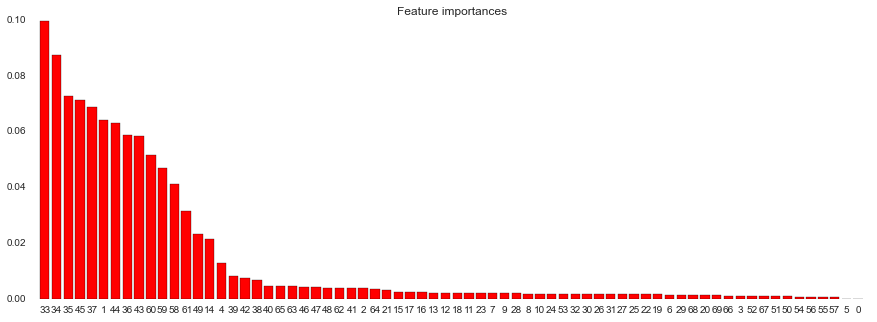

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


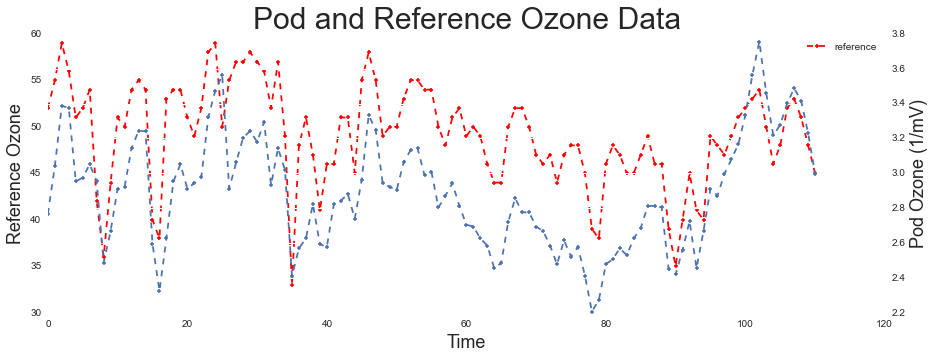

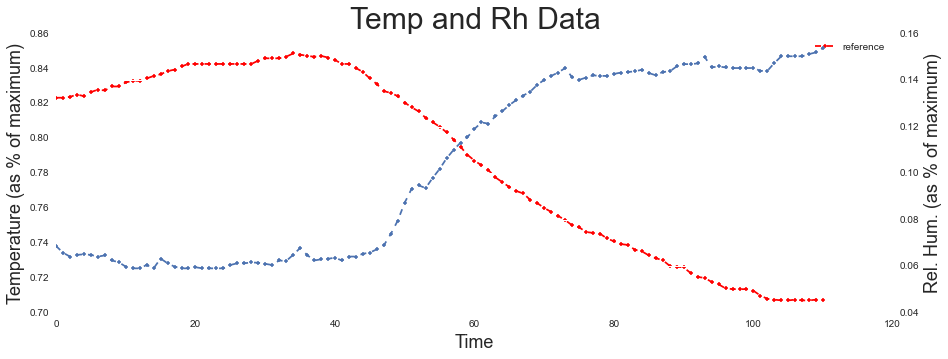

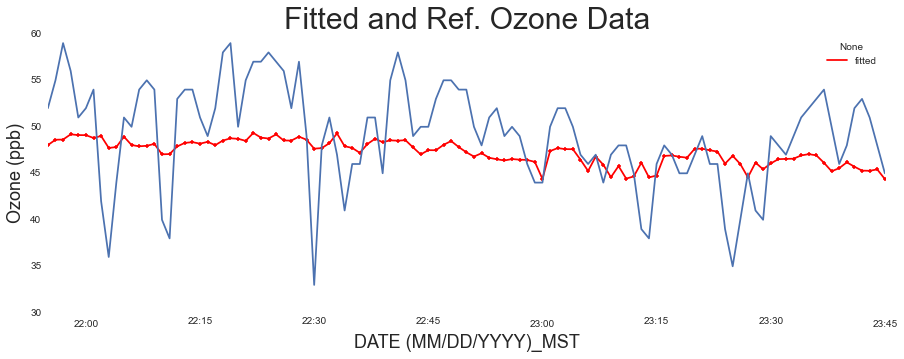

7-10 Holdout MSE:  27
nan
Feature ranking:
1. feature 36 (0.147181) temp_int_45
2. feature 33 (0.118257) temp_int_90
3. feature 37 (0.105224) temp_int_30
4. feature 34 (0.102310) temp_int_75
5. feature 35 (0.072347) temp_int_60
6. feature 44 (0.070275) O3_cu
7. feature 49 (0.064125) ln_temp_int_90
8. feature 1 (0.054971) e2v03
9. feature 45 (0.053777) ln_O3
10. feature 43 (0.049820) O3_sq
11. feature 4 (0.021357) Zenith Angle [degrees]
12. feature 41 (0.006322) o3_int_45
13. feature 14 (0.005046) temp_slope_90
14. feature 38 (0.004834) o3_int_90
15. feature 48 (0.004685) ln_temp
16. feature 40 (0.004678) o3_int_60
17. feature 46 (0.004425) temp_sq
18. feature 2 (0.004387) Temp
19. feature 39 (0.004232) o3_int_75
20. feature 18 (0.004197) temp_slope_30
21. feature 47 (0.004047) temp_cu
22. feature 62 (0.003960) temp_mult_rh
23. feature 63 (0.003767) temp_mult_rh_sq
24. feature 16 (0.003642) temp_slope_60
25. feature 65 (0.003598) ln_temp_mult_rh
26. feature 42 (0.003595) o3_int_30
27. f

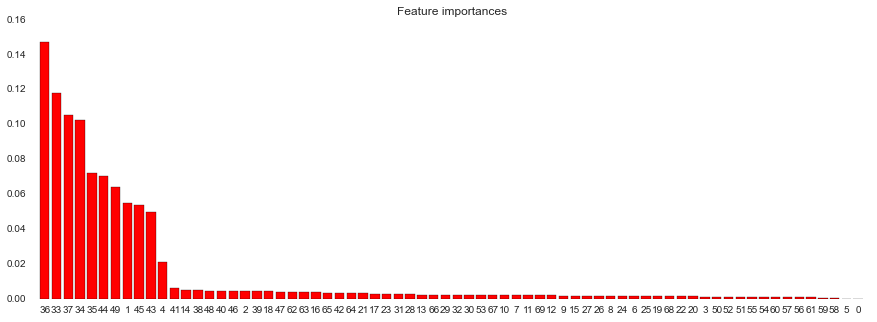

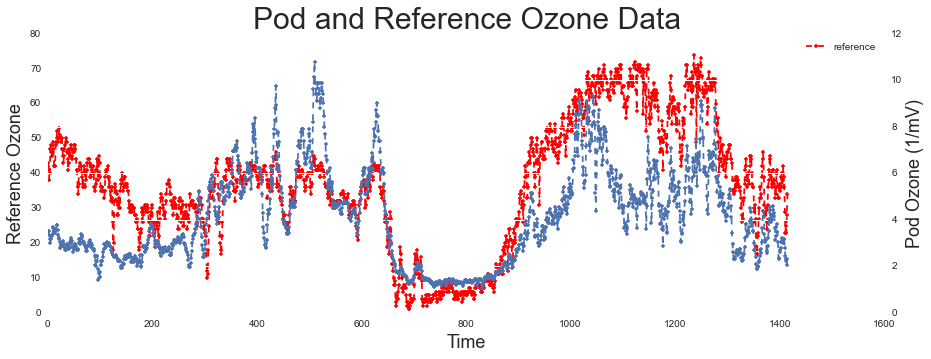

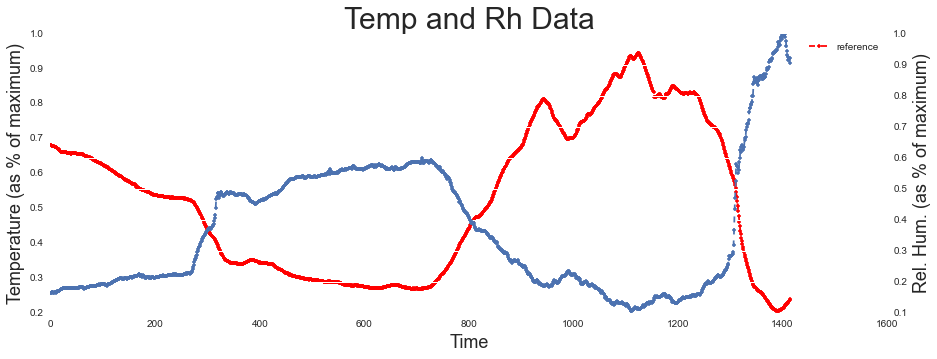

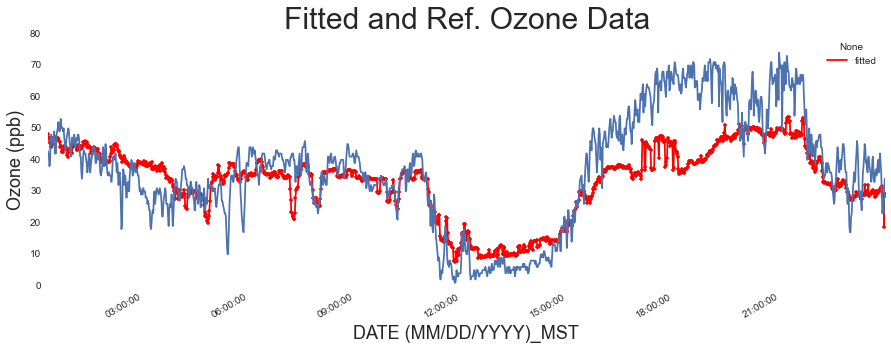

7-11 Holdout MSE:  114
nan
Feature ranking:
1. feature 34 (0.128706) temp_int_75
2. feature 37 (0.112586) temp_int_30
3. feature 35 (0.106850) temp_int_60
4. feature 33 (0.103297) temp_int_90
5. feature 36 (0.084036) temp_int_45
6. feature 43 (0.061876) O3_sq
7. feature 44 (0.056971) O3_cu
8. feature 1 (0.055990) e2v03
9. feature 45 (0.055612) ln_O3
10. feature 49 (0.045494) ln_temp_int_90
11. feature 60 (0.015239) 03_mult_rh_cu
12. feature 4 (0.012627) Zenith Angle [degrees]
13. feature 14 (0.009725) temp_slope_90
14. feature 59 (0.009082) 03_mult_rh_sq
15. feature 38 (0.008608) o3_int_90
16. feature 41 (0.008391) o3_int_45
17. feature 42 (0.008113) o3_int_30
18. feature 40 (0.007111) o3_int_60
19. feature 39 (0.005960) o3_int_75
20. feature 58 (0.005524) 03_mult_rh
21. feature 21 (0.004464) rh_slope_90
22. feature 61 (0.004181) ln_03_mult_rh
23. feature 62 (0.003478) temp_mult_rh
24. feature 65 (0.003366) ln_temp_mult_rh
25. feature 64 (0.003327) temp_mult_rh_cu
26. feature 63 (0.003

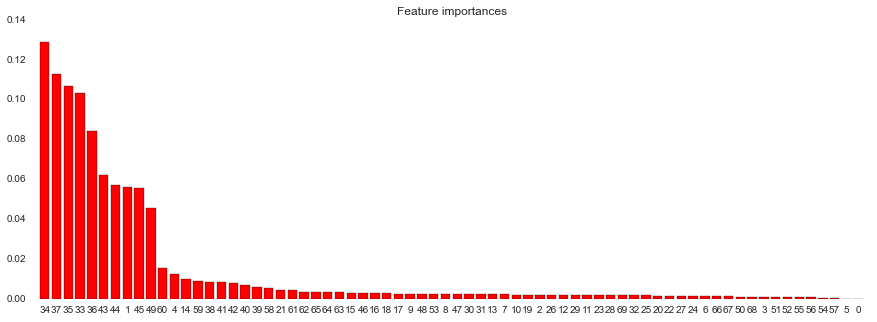

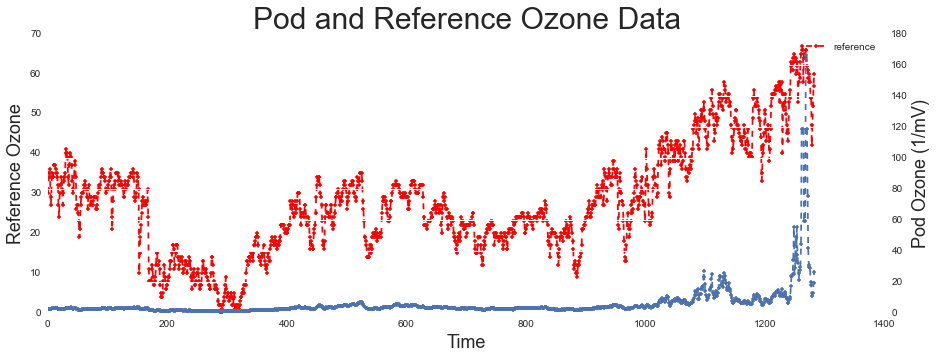

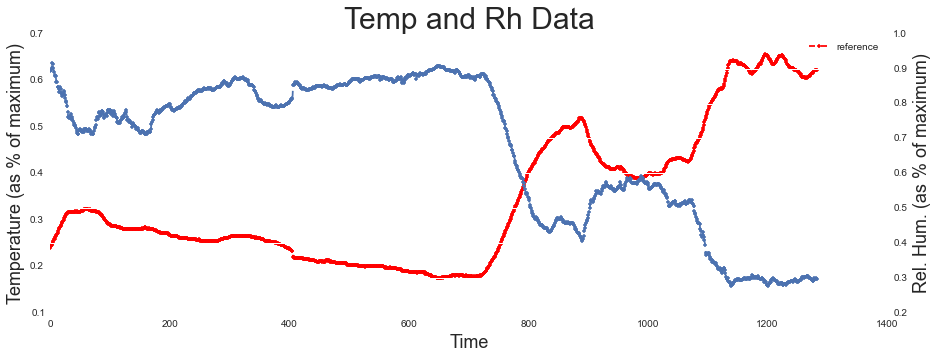

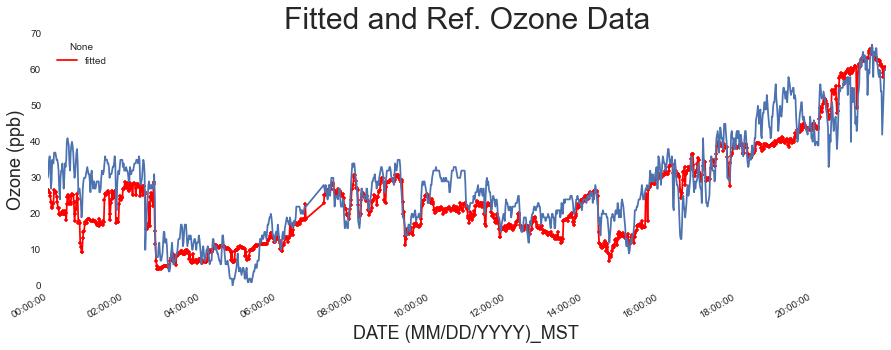

7-12 Holdout MSE:  38
nan
Feature ranking:
1. feature 35 (0.111781) temp_int_60
2. feature 34 (0.094625) temp_int_75
3. feature 33 (0.078536) temp_int_90
4. feature 36 (0.076909) temp_int_45
5. feature 37 (0.073691) temp_int_30
6. feature 1 (0.065107) e2v03
7. feature 44 (0.057134) O3_cu
8. feature 43 (0.056661) O3_sq
9. feature 45 (0.054853) ln_O3
10. feature 49 (0.050211) ln_temp_int_90
11. feature 61 (0.047195) ln_03_mult_rh
12. feature 59 (0.026555) 03_mult_rh_sq
13. feature 4 (0.016271) Zenith Angle [degrees]
14. feature 60 (0.015978) 03_mult_rh_cu
15. feature 14 (0.013969) temp_slope_90
16. feature 39 (0.013958) o3_int_75
17. feature 41 (0.013105) o3_int_45
18. feature 40 (0.011635) o3_int_60
19. feature 58 (0.010951) 03_mult_rh
20. feature 42 (0.009777) o3_int_30
21. feature 38 (0.009335) o3_int_90
22. feature 62 (0.004187) temp_mult_rh
23. feature 63 (0.004174) temp_mult_rh_sq
24. feature 2 (0.004128) Temp
25. feature 64 (0.003907) temp_mult_rh_cu
26. feature 47 (0.003851) temp

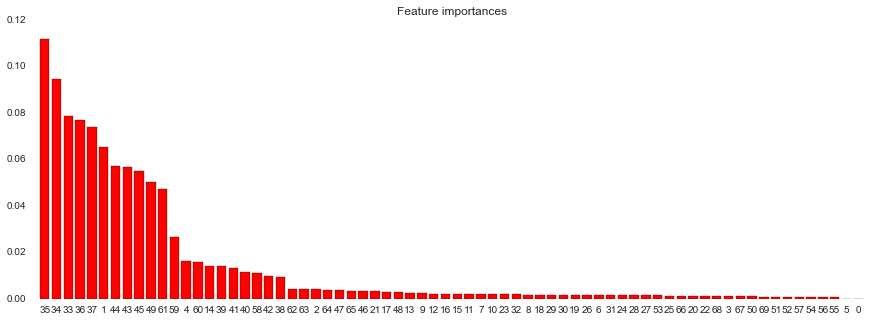

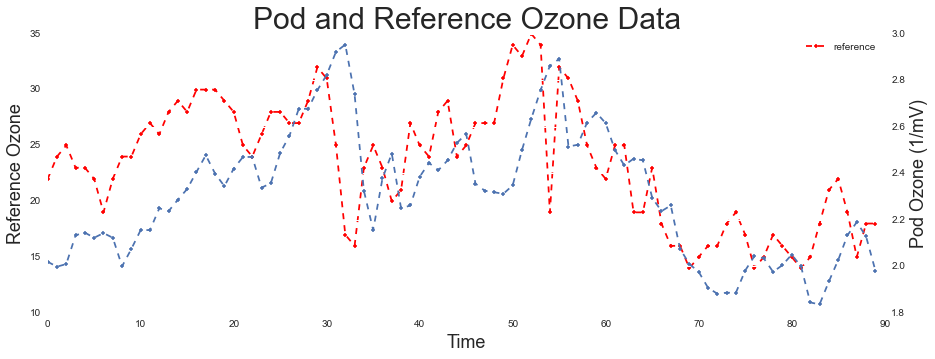

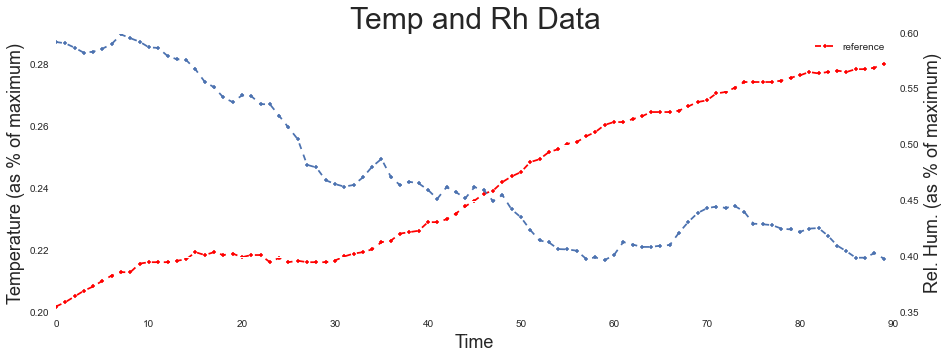

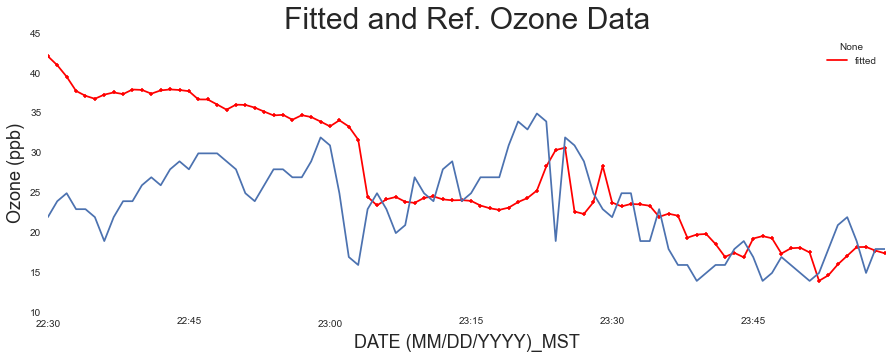

8-29 Holdout MSE:  63
nan
Feature ranking:
1. feature 60 (0.122111) 03_mult_rh_cu
2. feature 61 (0.112438) ln_03_mult_rh
3. feature 59 (0.103272) 03_mult_rh_sq
4. feature 58 (0.088708) 03_mult_rh
5. feature 44 (0.069131) O3_cu
6. feature 43 (0.062552) O3_sq
7. feature 45 (0.052764) ln_O3
8. feature 1 (0.046661) e2v03
9. feature 33 (0.039030) temp_int_90
10. feature 36 (0.034442) temp_int_45
11. feature 37 (0.029468) temp_int_30
12. feature 35 (0.025070) temp_int_60
13. feature 34 (0.022165) temp_int_75
14. feature 38 (0.014495) o3_int_90
15. feature 49 (0.013079) ln_temp_int_90
16. feature 40 (0.011289) o3_int_60
17. feature 4 (0.011237) Zenith Angle [degrees]
18. feature 39 (0.011058) o3_int_75
19. feature 41 (0.010507) o3_int_45
20. feature 42 (0.009539) o3_int_30
21. feature 14 (0.008376) temp_slope_90
22. feature 65 (0.006055) ln_temp_mult_rh
23. feature 48 (0.005559) ln_temp
24. feature 47 (0.005473) temp_cu
25. feature 63 (0.004885) temp_mult_rh_sq
26. feature 46 (0.004764) temp_

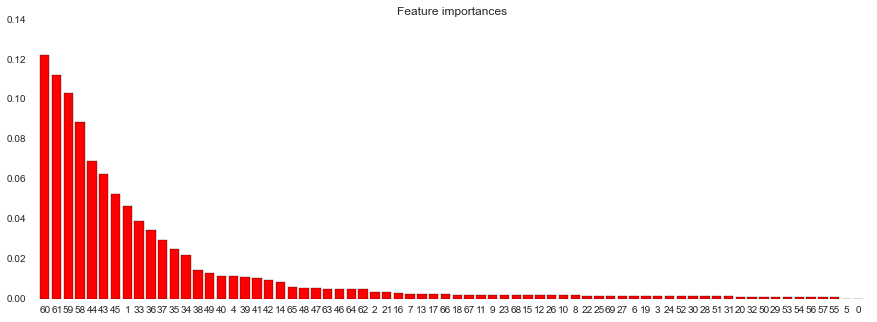

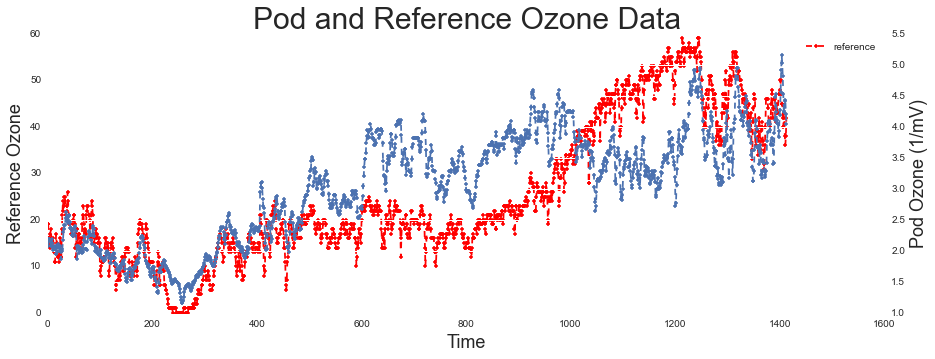

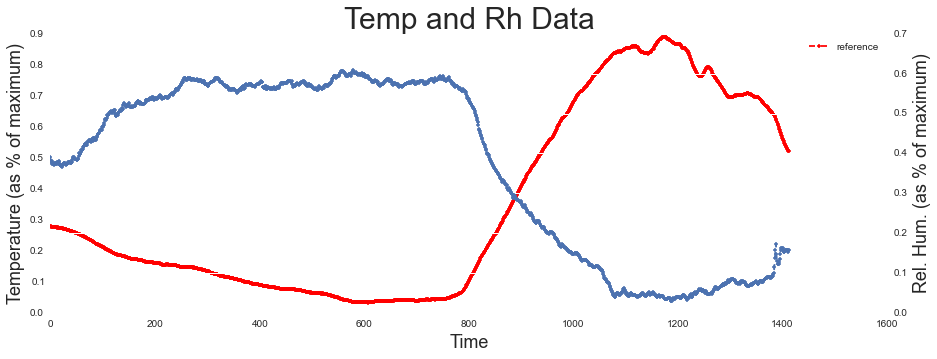

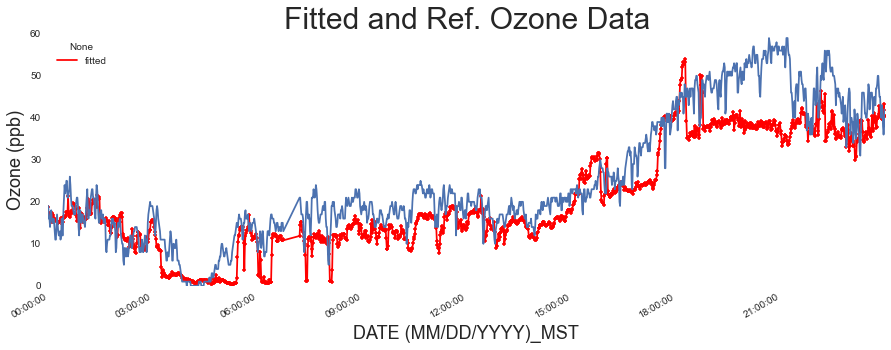

8-30 Holdout MSE:  55
nan
Feature ranking:
1. feature 37 (0.145976) temp_int_30
2. feature 34 (0.114460) temp_int_75
3. feature 33 (0.114380) temp_int_90
4. feature 36 (0.093927) temp_int_45
5. feature 35 (0.093597) temp_int_60
6. feature 1 (0.078639) e2v03
7. feature 45 (0.076097) ln_O3
8. feature 44 (0.058397) O3_cu
9. feature 43 (0.053576) O3_sq
10. feature 49 (0.018598) ln_temp_int_90
11. feature 4 (0.012393) Zenith Angle [degrees]
12. feature 14 (0.010867) temp_slope_90
13. feature 64 (0.005592) temp_mult_rh_cu
14. feature 42 (0.005385) o3_int_30
15. feature 40 (0.005277) o3_int_60
16. feature 38 (0.005164) o3_int_90
17. feature 62 (0.005106) temp_mult_rh
18. feature 65 (0.005016) ln_temp_mult_rh
19. feature 63 (0.004710) temp_mult_rh_sq
20. feature 39 (0.004203) o3_int_75
21. feature 46 (0.003773) temp_sq
22. feature 21 (0.003327) rh_slope_90
23. feature 48 (0.003290) ln_temp
24. feature 17 (0.003285) temp_slope_45
25. feature 47 (0.003169) temp_cu
26. feature 2 (0.002962) Temp
2

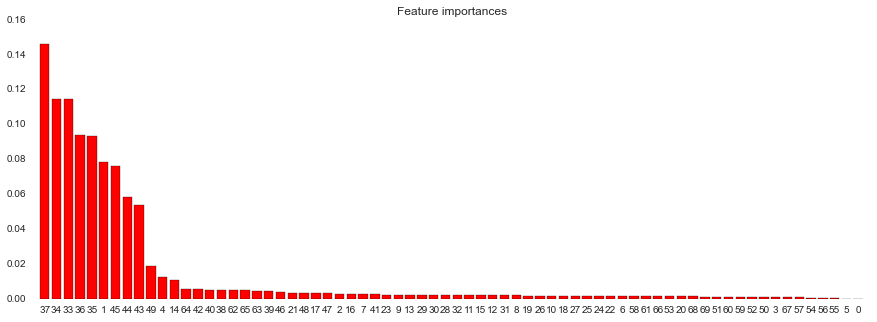

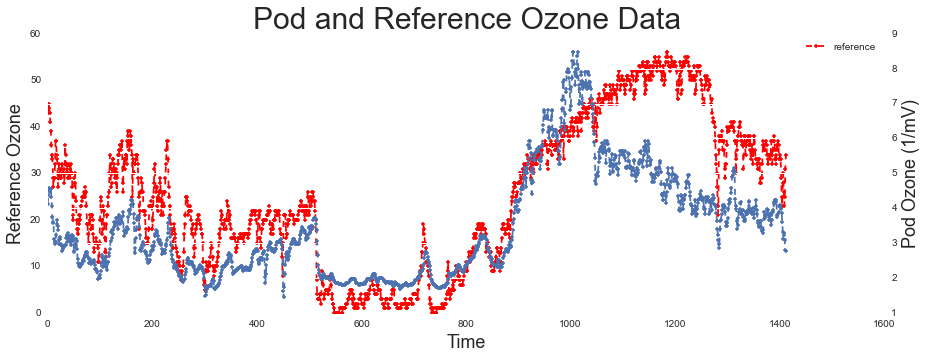

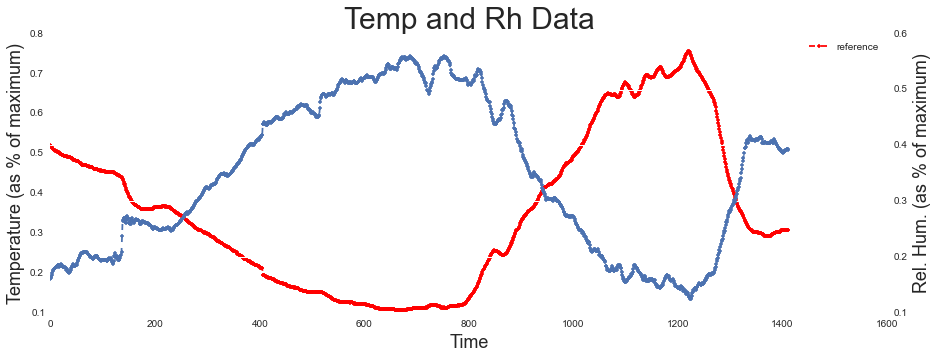

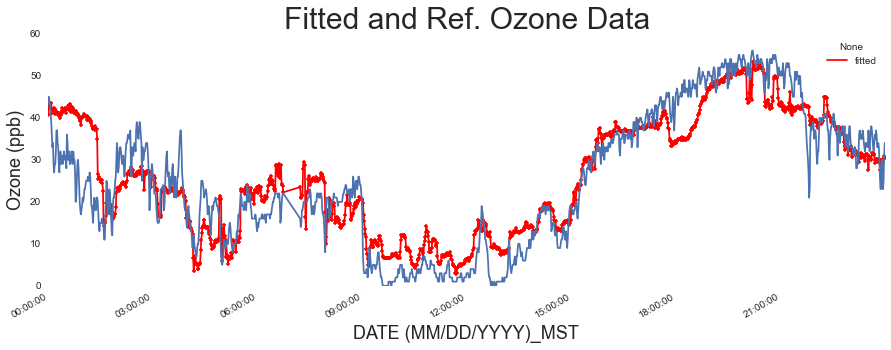

8-31 Holdout MSE:  41
nan
Feature ranking:
1. feature 37 (0.151231) temp_int_30
2. feature 36 (0.133073) temp_int_45
3. feature 33 (0.100158) temp_int_90
4. feature 35 (0.095611) temp_int_60
5. feature 34 (0.078062) temp_int_75
6. feature 45 (0.076035) ln_O3
7. feature 1 (0.058606) e2v03
8. feature 43 (0.052869) O3_sq
9. feature 44 (0.051576) O3_cu
10. feature 49 (0.027883) ln_temp_int_90
11. feature 4 (0.015749) Zenith Angle [degrees]
12. feature 14 (0.008149) temp_slope_90
13. feature 15 (0.007319) temp_slope_75
14. feature 41 (0.007042) o3_int_45
15. feature 42 (0.006847) o3_int_30
16. feature 65 (0.005422) ln_temp_mult_rh
17. feature 39 (0.005020) o3_int_75
18. feature 64 (0.005017) temp_mult_rh_cu
19. feature 63 (0.004901) temp_mult_rh_sq
20. feature 62 (0.004901) temp_mult_rh
21. feature 38 (0.004675) o3_int_90
22. feature 59 (0.004590) 03_mult_rh_sq
23. feature 7 (0.004541) o3_slope_90
24. feature 40 (0.003902) o3_int_60
25. feature 16 (0.003897) temp_slope_60
26. feature 17 (0.

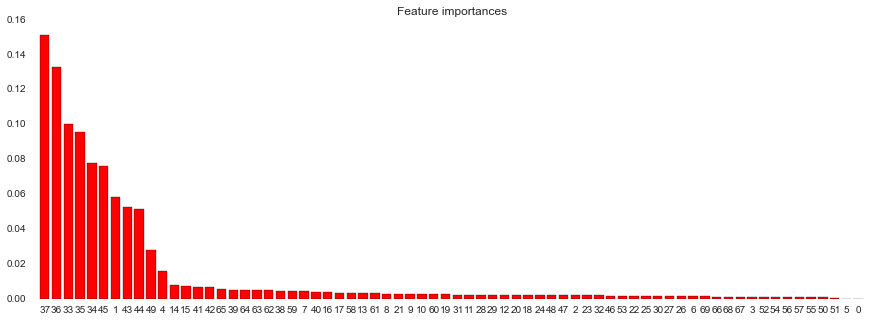

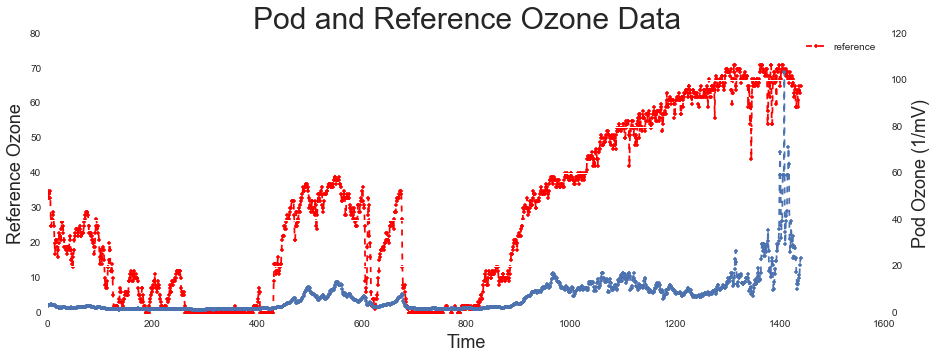

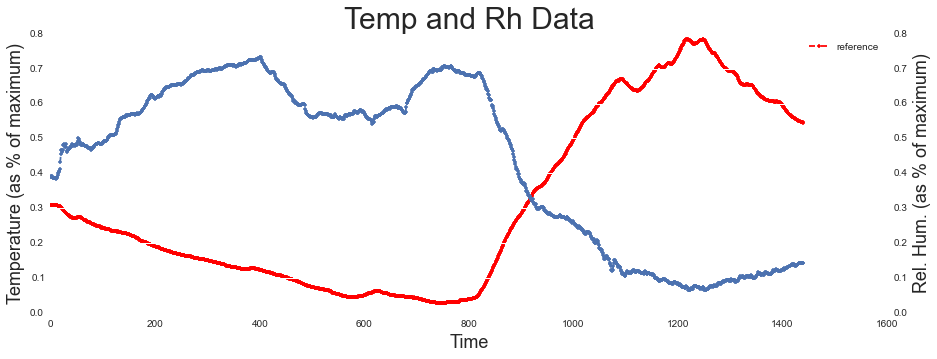

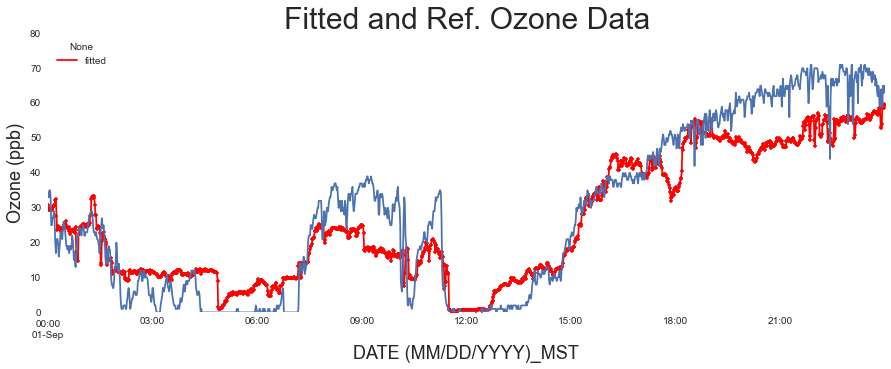

9-1 Holdout MSE:  79
nan
Feature ranking:
1. feature 60 (0.112157) 03_mult_rh_cu
2. feature 61 (0.087648) ln_03_mult_rh
3. feature 59 (0.087256) 03_mult_rh_sq
4. feature 58 (0.082130) 03_mult_rh
5. feature 43 (0.072737) O3_sq
6. feature 1 (0.067429) e2v03
7. feature 45 (0.055830) ln_O3
8. feature 44 (0.047394) O3_cu
9. feature 36 (0.043230) temp_int_45
10. feature 37 (0.039938) temp_int_30
11. feature 35 (0.033871) temp_int_60
12. feature 33 (0.025817) temp_int_90
13. feature 2 (0.023938) Temp
14. feature 48 (0.023213) ln_temp
15. feature 34 (0.020145) temp_int_75
16. feature 49 (0.013987) ln_temp_int_90
17. feature 38 (0.013378) o3_int_90
18. feature 47 (0.013282) temp_cu
19. feature 42 (0.011416) o3_int_30
20. feature 4 (0.011353) Zenith Angle [degrees]
21. feature 41 (0.011160) o3_int_45
22. feature 40 (0.009993) o3_int_60
23. feature 39 (0.009613) o3_int_75
24. feature 46 (0.009080) temp_sq
25. feature 14 (0.005034) temp_slope_90
26. feature 16 (0.004422) temp_slope_60
27. feature 

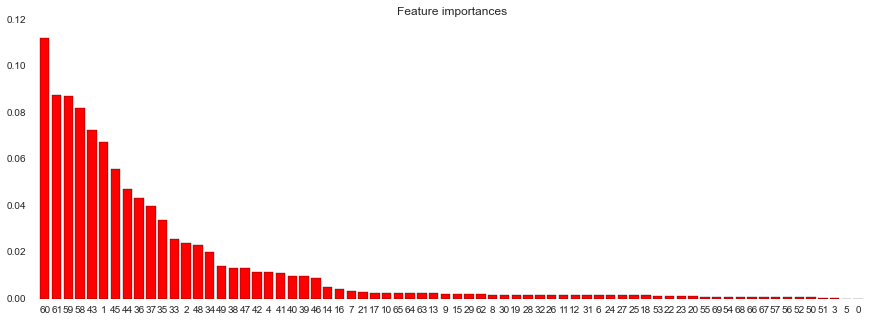

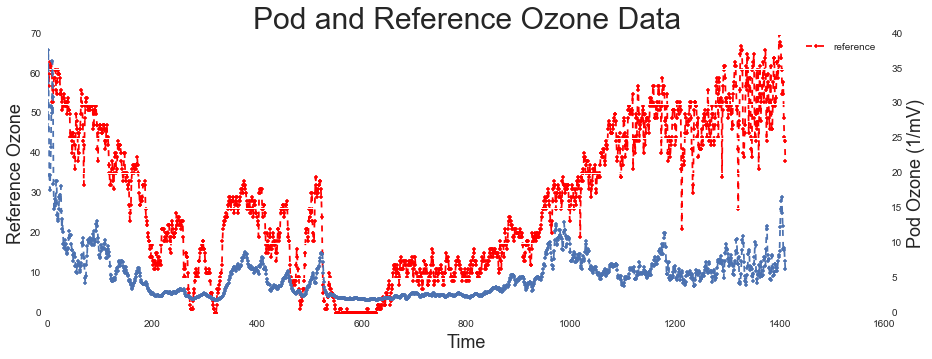

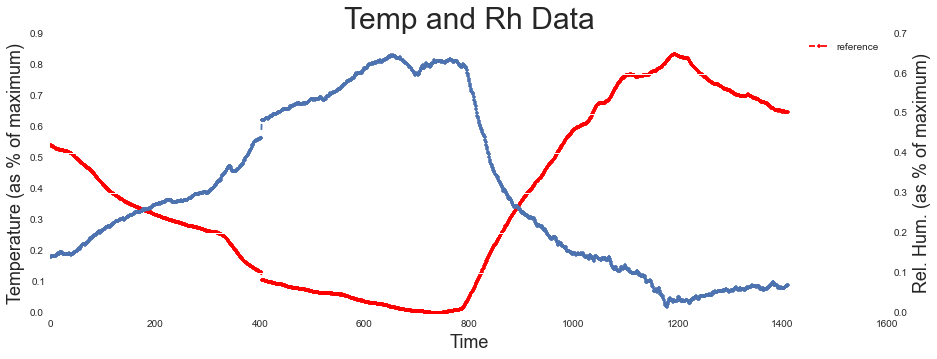

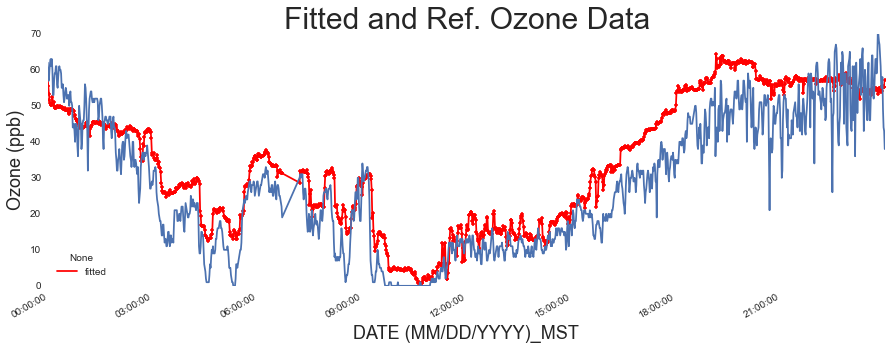

9-2 Holdout MSE:  82
nan
Feature ranking:
1. feature 61 (0.163124) ln_03_mult_rh
2. feature 59 (0.157458) 03_mult_rh_sq
3. feature 60 (0.139438) 03_mult_rh_cu
4. feature 58 (0.122815) 03_mult_rh
5. feature 43 (0.056015) O3_sq
6. feature 1 (0.053010) e2v03
7. feature 45 (0.051844) ln_O3
8. feature 44 (0.050334) O3_cu
9. feature 36 (0.018945) temp_int_45
10. feature 37 (0.018415) temp_int_30
11. feature 34 (0.018215) temp_int_75
12. feature 33 (0.017967) temp_int_90
13. feature 35 (0.015794) temp_int_60
14. feature 4 (0.008686) Zenith Angle [degrees]
15. feature 49 (0.006761) ln_temp_int_90
16. feature 46 (0.005014) temp_sq
17. feature 2 (0.004894) Temp
18. feature 38 (0.004547) o3_int_90
19. feature 47 (0.004342) temp_cu
20. feature 21 (0.004218) rh_slope_90
21. feature 39 (0.004213) o3_int_75
22. feature 48 (0.003903) ln_temp
23. feature 42 (0.003879) o3_int_30
24. feature 40 (0.003861) o3_int_60
25. feature 41 (0.003789) o3_int_45
26. feature 14 (0.003193) temp_slope_90
27. feature 64

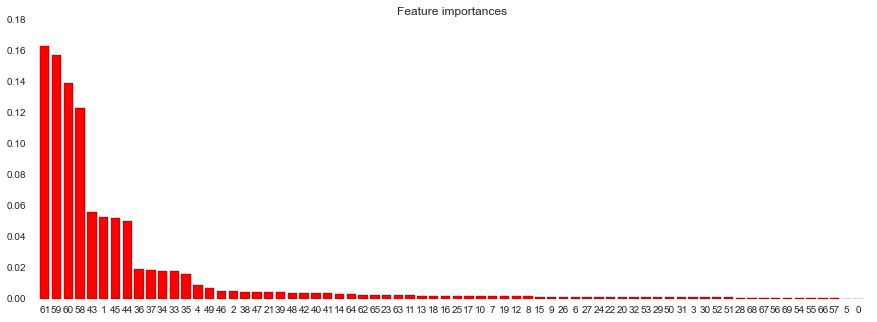

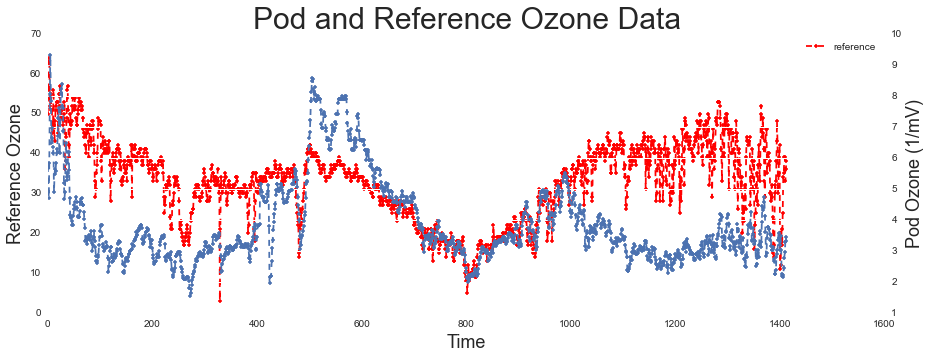

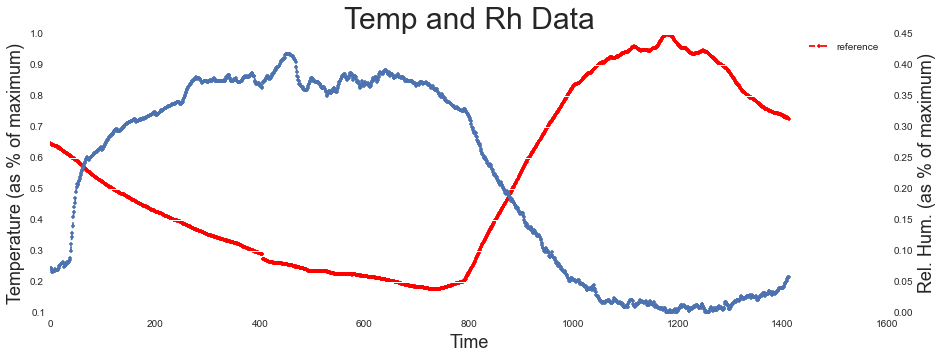

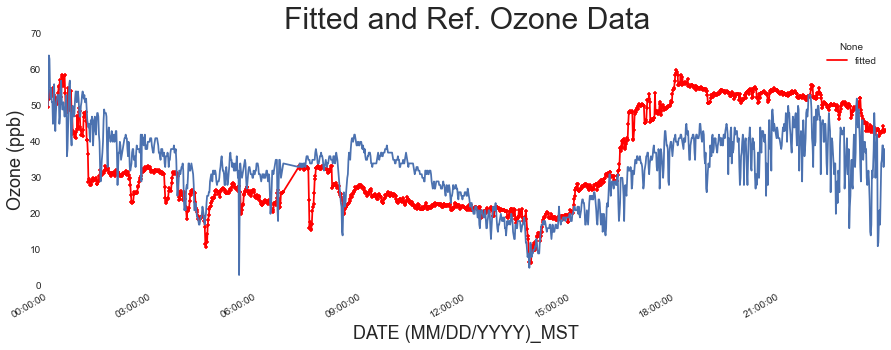

9-3 Holdout MSE:  108


In [101]:
# define the dataset
import sklearn.preprocessing as pp

#call the function that scales the features and creates a day column
df_fit, days = scale_features_and_create_day_column(df_all, features, ref_column)
        
#initialize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
o3_max = []
rh_max_percent = []
temp_max_percent = []
o3_min = []
rh_min_percent = []
temp_min_percent = []
o3_mean = []
rh_mean_percent = []
temp_mean_percent = []
o3_stdev = []
rh_stdev_percent = []
temp_stdev_percent = []
pod_o3_max = []
pod_o3_min = []
pod_o3_mean = []
pod_o3_stdev = []

count = 1
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_day, MSE_T_day = fit_rfr_and_find_MSE(fs_features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    
    day_date.append(d)
    #count_append.append(count)
    
    if count == 1 and options == 1:
        MSE_H = MSE_H_day
        MSE_T = MSE_T_day
    elif count == 1:
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
    elif options == 1:
        MSE_H = np.dstack((MSE_H,MSE_H_day))
        MSE_T = np.dstack((MSE_T,MSE_T_day))
    else:
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
        
    count +=1

    
    #call the function that finds the daily min and max
    o3_max_day, temp_max_day, rh_max_day, o3_min_day, temp_min_day, rh_min_day, o3_mean_day, temp_mean_day, rh_mean_day, o3_stdev_day, temp_stdev_day, rh_stdev_day, pod_o3_max_day, pod_o3_min_day, pod_o3_mean_day, pod_o3_stdev_day = find_daily_min_max(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    o3_max.append(o3_max_day)
    temp_max_percent.append(temp_max_day*100)
    rh_max_percent.append(rh_max_day*100)
    o3_min.append(o3_min_day)
    temp_min_percent.append(temp_min_day*100)
    rh_min_percent.append(rh_min_day*100)
    o3_mean.append(o3_mean_day)
    temp_mean_percent.append(temp_mean_day*100)
    rh_mean_percent.append(rh_mean_day*100)
    o3_stdev.append(o3_stdev_day)
    temp_stdev_percent.append(temp_stdev_day*100)
    rh_stdev_percent.append(rh_stdev_day*100)
    pod_o3_max.append(pod_o3_max_day)
    pod_o3_min.append(pod_o3_min_day)
    pod_o3_mean.append(pod_o3_mean_day)
    pod_o3_stdev.append(pod_o3_stdev_day)
    
       
#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [102]:
if options == 1:
    #first array is  [[day 1, day 2, ..., day n (i = 0 & j = 0)] [day 1, day 2, ..., day n (i = 0, j = 1)] [day 1, day 2, ..., day n(i = 0, j = n)]
    #second array is [[day 1, day 2, ..., day n (i = 1 & j = 0)] [day 1, day 2, ..., day n (i = 1, j = 1)] [day 1, day 2, ..., day n(i = 1, j = n)]
    #nth array is [[day 1, day 2, ..., day n (i = n & j = 0)] [day 1, day 2, ..., day n (i = n, j = 1)] [day 1, day 2, ..., day n(i = n, j = n)]
    print MSE_H
else: 
    print 'mean MSE = ', int(np.mean(MSE_H))
    print 'Daily MSE = ' + str(MSE_H)

mean MSE =  67
Daily MSE = [27, 114, 38, 63, 55, 41, 79, 82, 108]


In [103]:
if options == 1:
    MSE_H_per_day = MSE_H.mean(axis=2, dtype = int)
    print MSE_H_per_day

In [104]:
if options == 1:    
    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    imgplot = plt.imshow(MSE_H_per_day)
    imgplot.set_cmap('hot')
    #imgplot.set_clim(60,71)
    ax.set_aspect('equal')

    plt.colorbar(orientation='vertical')
    plt.show()
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Maximum Features at Each Split')

In [105]:
if options == 1:
    min_MSE_H = MSE_H_per_day.min()
    i,j = np.where(MSE_H_per_day == min_MSE_H)
    i = i + 1
    j = (j + 1)*5
    print 'Max features = ' + str(i)
    print 'Max depth = ' + str(j)
    print 'MSE for the holdout data = ' + str(min_MSE_H)

In [106]:
####Plot the holdout data MSE for each day.

In [242]:
def plot_daily_mse_and_features_for_day(MSE_H, day_date,feat_to_compare, title, sec_axis_label):
    from matplotlib import rc
    rc('mathtext', default='regular')

    indices = day_date
    
    #Plot the feature importances of the forest
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title(title, fontsize = 30)
    ax.bar(range(len(day_date)), MSE_H,  color="r", align="center")
    plt.xticks(range(len(day_date)), indices)
    plt.xlim([-1, len(day_date)])
    ax.set_xlabel('Date', fontsize = 18)
    ax.set_ylabel('MSE (ppb)', fontsize = 18)
    ax2 = ax.twinx()  
    ax2.set_ylabel(sec_axis_label, fontsize = 18)
    plt.plot(range(len(day_date)), feat_to_compare, marker = 'o', linestyle = '--')
    plt.show()

In [243]:
plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_mean,'Mean Ozone', 'ppb')
plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_stdev,'St. Dev. in Ozone', 'ppb')

plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_mean_percent,'Mean Temp.','% of Max. during Collocation')
plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_stdev_percent,'St. Dev.','% of Max. during Collocation')

plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_mean_percent,'Mean Rel. Humid.','% of Max. during Collocation')
plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_stdev_percent,'St. Dev. Rel. Humid.','% of Max. during Collocation')

plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_mean,'Mean Pod Ozone','% of Max. during Collocation')
plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_stdev,'St. Dev. Pod Ozone','% of Max. during Collocation')

NameError: name 'day_date' is not defined

#Forward Selection for Random Forests

In [29]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['Zenith Angle [degrees]','UnixTime','ref_o3_smooth', ref_column]
features = [f for f in features if f not in leave_out]

In [33]:
rfr = sk.RandomForestRegressor(n_estimators=10, oob_score = True, n_jobs = -1)

fs_features, MSE_T, MSE_H = forward_selection_lodo(rfr, features, df_all[[ref_column] + features].dropna())
#+['days from start']
print fs_features

(array(['O3_sq'], 
      dtype='|S32'), array([ 2.]))
(array(['03_mult_temp_cu'], 
      dtype='|S32'), array([ 1.]))


/Applications/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:600: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


KeyboardInterrupt: 

####Make plots of the MSE for the training and holdout data.

In [ ]:
x = range(0, len(MSE_T))
plt.figure()
plt.plot(x, MSE_T, 'ro-')
plt.ylabel('Normalized Training RSS')
plt.figure()
plt.plot(x, MSE_H, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Normalized Holdout RSS')
print MSE_H

In [35]:
fs_features = all_features

###Plot the learning curves

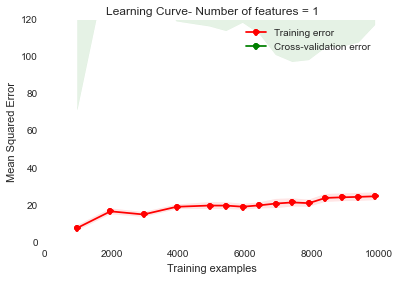

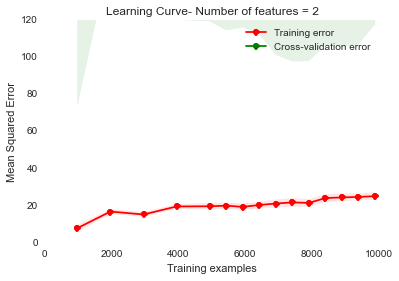

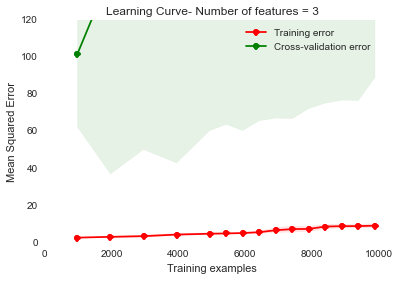

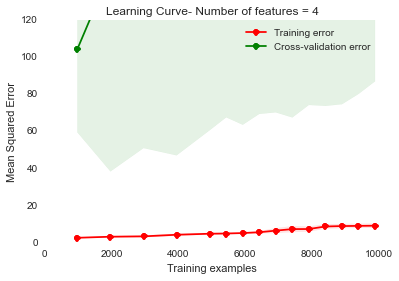

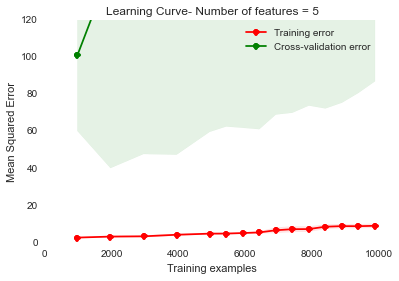

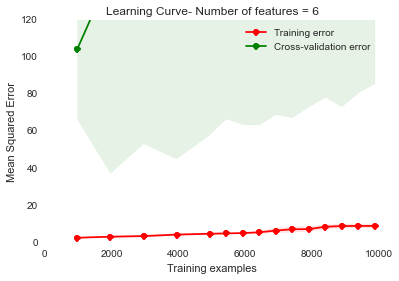

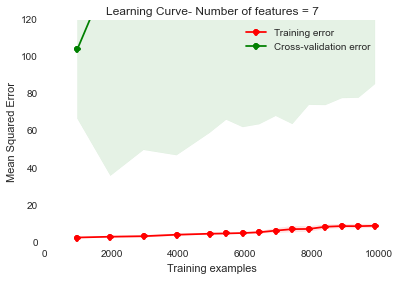

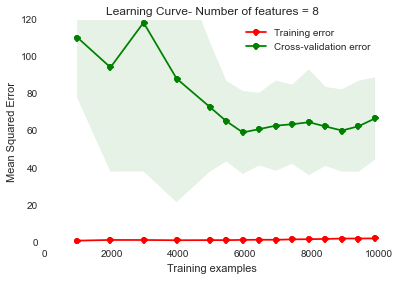

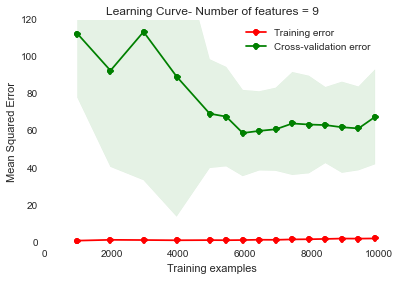

In [38]:
cv = lol
ylim = (0,120)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
#declare the reference data 
y = df_all[ref_column].values

for i in range(1,10):
    X = df_all[fs_features[:i]].values 
    title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(rfr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

In [244]:
fs_features = ['03_mult_rh_cu', '03_mult_rh_sq', 'e2v03', 'O3_cu', '03_mult_rh', 'ln_O3', 'O3_sq', 'temp_int_30', 'temp_int_90', 'ln_03_mult_rh', 'temp_int_60', 'temp_int_45', 'temp_cu', 'temp_int_75','ln_temp', 'Temp']
num_good_feat = len(fs_features)

In [246]:
fitted_holdout_o3 = []
for d in days:
    
    #call the df_subset function to make numpy arrays out of the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features[:num_good_feat], df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d]) 
    
    #fit a linear regression on the training data
    rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
    rfr.fit(X_T, y_T)
        
    if d == days[0]:
        fitted_holdout_o3 = rfr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, rfr.predict(X_H)))

df_fit_rf = df_all.copy()
df_fit_rf['O3_fit'] = fitted_holdout_o3

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

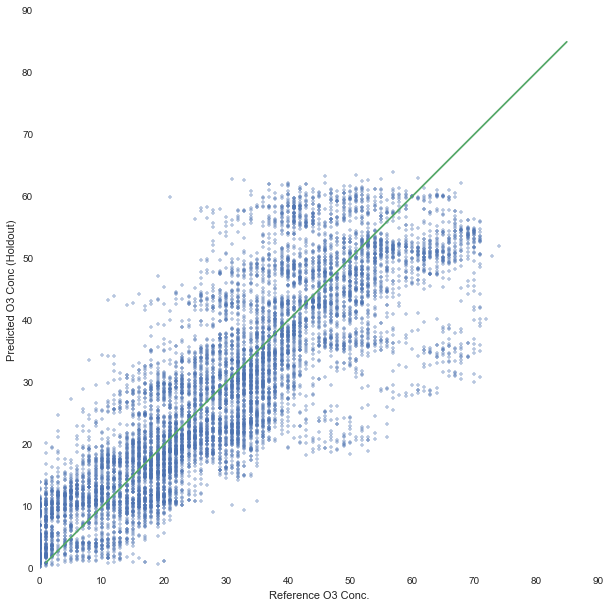

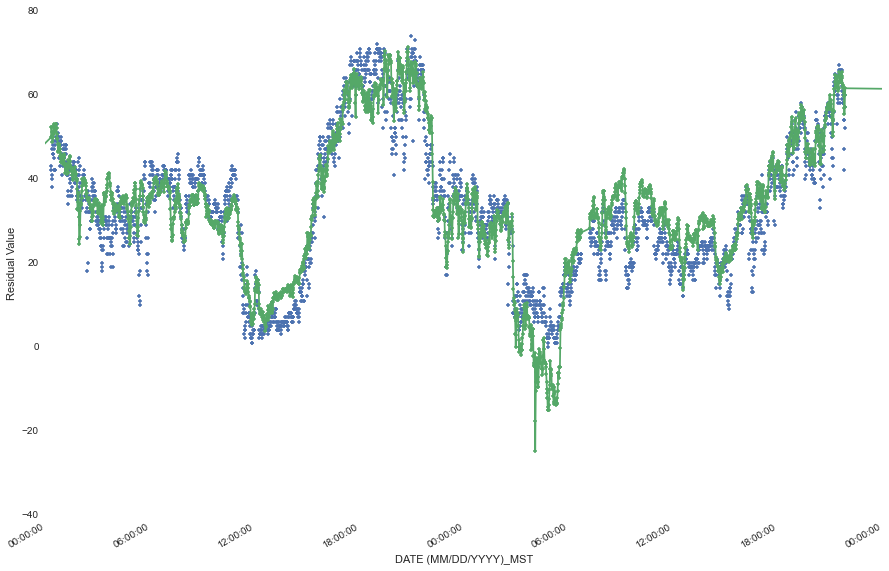

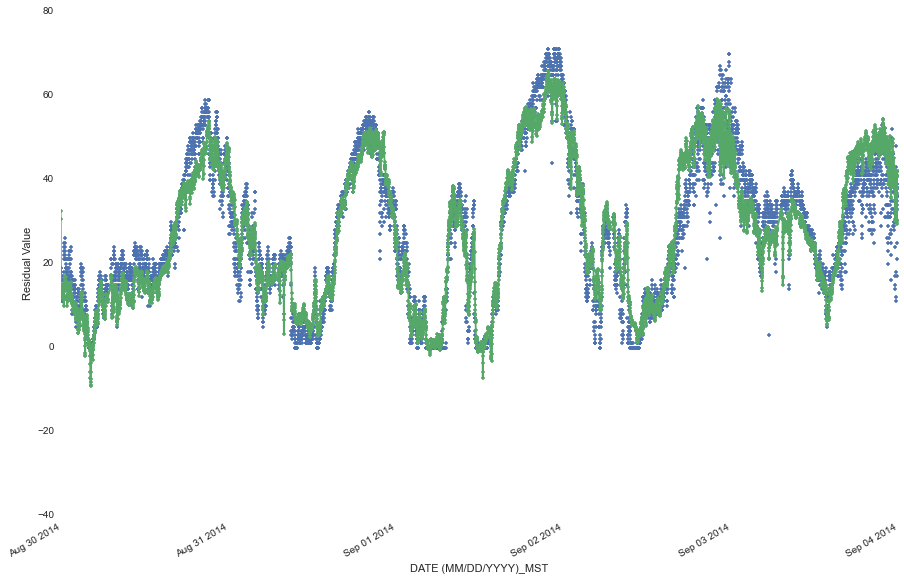

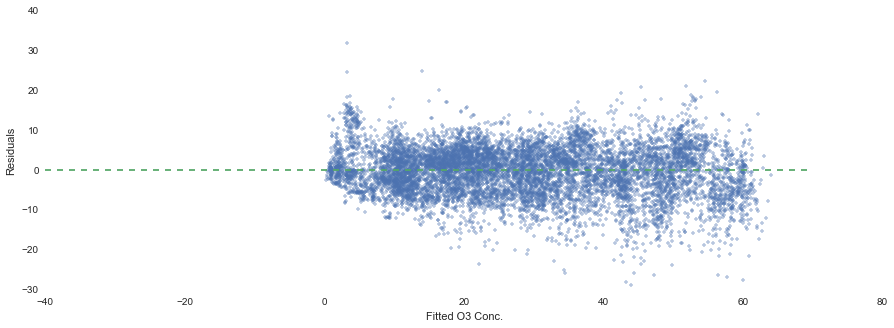

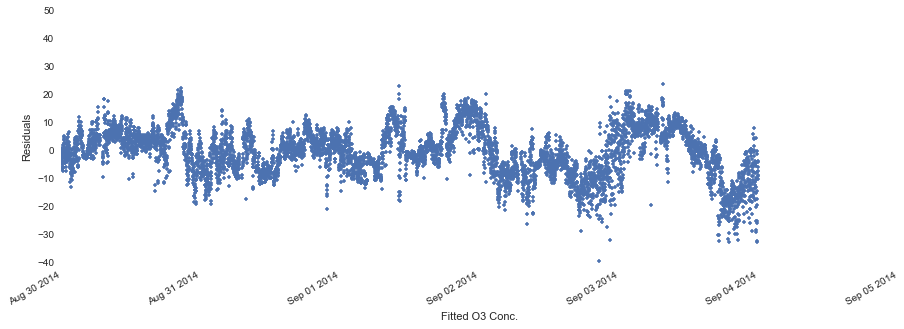

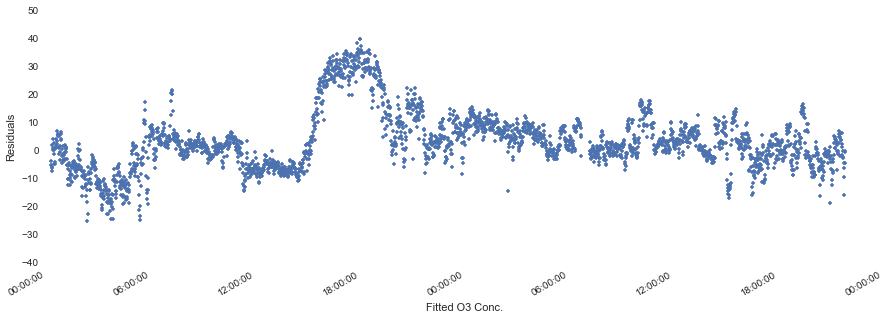

In [247]:
fitted_vs_ref_plot(df_fit_rf)
plot_fitted_and_ref_vs_time(df_fit_rf, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_fit_rf, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_fit_rf)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

#Vector Support Machine

In [248]:
def make_numpy_arrays_for_tr_and_holdout(features, df_T, df_H):
    print df_T
    X_T = df_T[features].values
    X_H = df_H[features].values
    y_T = df_T[ref_column].values
    y_H = df_H[ref_column].values
    return X_T, y_T, X_H, y_H

In [249]:
from sklearn import svm

#fit random forest and finds MSE
def fit_vsm_and_find_MSE(features, df_T, df_H, d):
    
    vsm = svm.SVR(kernel = 'linear')
        
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])                
    #fit a linear regression on the training data
    vsm.fit(X_T, y_T)  
        
    #fit the holdout data for the day
    df_H['O3_fit'] = vsm.predict(X_H)
        
    #plot the feature importances
    #plot_importance(vsm, forest)
    #plot the ozone data for the day
    #plot_ref_and_pod_ozone_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    #plot_temp_and_rh_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    plot_fitted_and_ref_ozone_for_each_day(df_H['O3_fit'], df_fit[df_fit.day == d])
        
    MSE_H = int(np.mean((y_H - vsm.predict(X_H))**2))
    MSE_T = int(np.mean((y_T - vsm.predict(X_T))**2))
            
    print d,'Holdout MSE: ', MSE_H
    return MSE_H, MSE_T

In [250]:
#Calculate the training and holdout MSE for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
count = 1
MSE_H = []
MSE_T = []
day_date = []
count_append = []
for d in days:
    MSE_H_day, MSE_T_day = fit_vsm_and_find_MSE(fs_features, df_all[df_all.day != d], df_all[df_all.day == d],d)
    
    day_date.append(d)
    count_append.append(count)
    
    MSE_H.append(MSE_H_day)
    MSE_T.append(MSE_T_day)
    
    count += 1
print 'Cross-Validation Holdout MSE: ', np.mean(MSE_H)
print 'Daily Cross-Validation Holdout MSE: ', MSE_H

AttributeError: 'DataFrame' object has no attribute 'day'

#AdaBoost

In [ ]:
import sklearn.tree as tsk

#dt1 = tsk.DecisionTreeRegressor(max_depth=4) create single tree
ada = sk.AdaBoostRegressor(n_estimators = 175, learning_rate = 3)
staged_score = (X,y)

#dt1_reg = dt1.fit(X,y)   
ada_reg = ada.fit(X,y)

In [ ]:
#Get the Ada Boost classifier results
ada_cv = sk.AdaBoostClassifier(n_estimators = 175, learning_rate = 3)
#get the cross-validation scores
scores = cvs(ada_cv, X, y, cv = 10, scoring='r2')
scores.mean() 